In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import math
import glob
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import re

In [4]:
# % Used Smartphone: LGE-lge-LG-H815-5.1                                             
# % Smartphone's Accelerometer: LGE Accelerometer - Vendor: BOSCH                    
# % --> Version: 1                                                                   
# % --> Min - Max Delay: 5000us - 65535000us                                         
# % --> Maximum Range: 16.000000263891405 G                                          
# % --> Resolution: 1.2136514986004396E-4 G                                          
                                                                                    
# % SensorTag's Accelerometer: MPU-9250 MEMS MotionTracking Device - Invensense      
# % --> Maximum Range: 16 G                                                          
# % --> Resolution: 0.00024 G                                                        
                                                                                    
# % MAC Address; Sensor_ID; Position; Device Model                                   
# %f8:95:c7:f3:ba:82; 0; RIGHTPOCKET; lge-LG-H815-5.1                                
# %C4:BE:84:70:64:8A; 1; CHEST; SensorTag                                            
# %C4:BE:84:70:0E:80; 3; WRIST; SensorTag                                            
# %C4:BE:84:71:A5:02; 2; WAIST; SensorTag                                            
# %B0:B4:48:B8:77:03; 4; ANKLE; SensorTag                                            
                                                                                    
# % Sensor_Type:                                                                     
# % Accelerometer = 0                                                                
# % Gyroscope = 1                                                                    
# % Magnetometer = 2  

In [5]:
datapath = "../../../CAGE/data/UMAFall_Dataset/"
all_files = glob.glob(os.path.join(datapath, "*.csv"))

In [6]:
def parse_filename(filename):
    pattern = r'UMAFall_Subject_(\d+)_(ADL|Fall)_([a-zA-Z_]+)_(\d+)_(\d{4}-\d{2}-\d{2})_.*\.csv'
    match = re.match(pattern, filename)
    
    if match:
        subject_id = int(match.group(1))
        activity_type = match.group(2)
        activity = match.group(3)
        trial = int(match.group(4))
        date = match.group(5)
        return subject_id, activity_type, activity, trial, date
    return None

In [7]:
def read_all_sensors_file(filepath):
    sensor_data = {
        'RIGHTPOCKET': {'id': None, 'data': []},
        'CHEST': {'id': None, 'data': []},
        'WRIST': {'id': None, 'data': []},
        'WAIST': {'id': None, 'data': []},
        'ANKLE': {'id': None, 'data': []}
    }
    
    with open(filepath, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if ';' in line and any(pos in line for pos in sensor_data.keys()):
                parts = line.strip().split(';')
                if len(parts) >= 3:
                    sensor_id = parts[1].strip()
                    position = parts[2].strip()
                    if position in sensor_data:
                        sensor_data[position]['id'] = sensor_id
        
        data_start = False
        for line in lines:
            if '% TimeStamp; Sample No;' in line:
                data_start = True
                continue
            
            if data_start:
                try:
                    values = [float(v.strip()) for v in line.split(';')]
                    sensor_id = str(int(values[-1]))
                    sensor_type = int(values[-2])
                    data = values[2:5]
                    
                    for position, info in sensor_data.items():
                        if info['id'] == sensor_id:
                            info['data'].append([*data, sensor_type])
                except:
                    continue
    
    for position in sensor_data:
        if sensor_data[position]['data']:
            sensor_data[position]['data'] = np.array(sensor_data[position]['data'])
        else:
            sensor_data[position]['data'] = None
            
    return sensor_data

In [8]:
def process_sensor_data(sensor_data):
    processed_data = {}
    valid_lengths = []
    
    for position, data in sensor_data.items():
        if data['data'] is not None:
            acc_mask = data['data'][:, -1] == 0
            gyro_mask = data['data'][:, -1] == 1
            mag_mask = data['data'][:, -1] == 2
            
            acc_data = data['data'][acc_mask][:, :3] if np.any(acc_mask) else np.array([])
            gyro_data = data['data'][gyro_mask][:, :3] if np.any(gyro_mask) else np.array([])
            mag_data = data['data'][mag_mask][:, :3] if np.any(mag_mask) else np.array([])
            
            if len(acc_data) > 0:
                valid_lengths.append(len(acc_data))
            if len(gyro_data) > 0:
                valid_lengths.append(len(gyro_data))
            if len(mag_data) > 0:
                valid_lengths.append(len(mag_data))
    
    if not valid_lengths:
        return None
        
    min_length = min(valid_lengths)
    
    for position, data in sensor_data.items():
        if data['data'] is not None:
            acc_mask = data['data'][:, -1] == 0
            gyro_mask = data['data'][:, -1] == 1
            mag_mask = data['data'][:, -1] == 2
            
            if np.any(acc_mask):
                acc_data = data['data'][acc_mask][:min_length, :3]
                acc_cols = [f'{position.lower()}_acc_x', f'{position.lower()}_acc_y', f'{position.lower()}_acc_z']
                processed_data.update(dict(zip(acc_cols, acc_data.T)))
            
            if np.any(gyro_mask):
                gyro_data = data['data'][gyro_mask][:min_length, :3]
                gyro_cols = [f'{position.lower()}_gyro_x', f'{position.lower()}_gyro_y', f'{position.lower()}_gyro_z']
                processed_data.update(dict(zip(gyro_cols, gyro_data.T)))
            
            if np.any(mag_mask):
                mag_data = data['data'][mag_mask][:min_length, :3]
                mag_cols = [f'{position.lower()}_mag_x', f'{position.lower()}_mag_y', f'{position.lower()}_mag_z']
                processed_data.update(dict(zip(mag_cols, mag_data.T)))
    
    if not processed_data:
        return None
        
    return pd.DataFrame(processed_data)

In [9]:
def prepare_data(features):
    sensor_columns = [col for col in features.columns if any(x in col for x in ['acc', 'gyro', 'mag'])]
    scaler = StandardScaler()
    features_scaled = features.copy()
    features_scaled[sensor_columns] = scaler.fit_transform(features[sensor_columns])
    features_scaled = features_scaled[sensor_columns + ['activity']]
    
    print ("columns : ", features_scaled.columns)
    adl_count = features_scaled['activity'].value_counts()[0]
    fall_count = features_scaled['activity'].value_counts()[1]

    adl_mask = features_scaled['activity'] == 0
    adl_data = features_scaled[adl_mask]
    adl1 = adl_data.iloc[:int(adl_count * 0.8)]
    adl2 = adl_data.iloc[int(adl_count * 0.2):]

    fall_mask = features_scaled['activity'] == 1
    fall_data = features_scaled[fall_mask]
    fall1 = fall_data.iloc[:int(fall_count * 0.8)]
    fall2 = fall_data.iloc[int(fall_count * 0.2):]
    
    train_data, train_labels = split_sequences(adl1, WINDOW_LENGTH, STRIDE)
    test_adl_data, test_adl_labels = split_sequences(adl2, WINDOW_LENGTH, STRIDE)
    test_fall1_data, test_fall1_labels = split_sequences(fall1, WINDOW_LENGTH, STRIDE)
    test_fall2_data, test_fall2_labels = split_sequences(fall2, WINDOW_LENGTH, STRIDE)
    
    return train_data, test_adl_data, test_fall1_data, test_fall2_data

In [10]:
def split_sequences(sequences, n_steps, stride):
    X, y = [], []
    for i in range(0, len(sequences) - n_steps + 1, stride):
        end_ix = i + n_steps
        
        seq_x = sequences.iloc[i:end_ix].iloc[:, :-1]  
        seq_y = sequences.iloc[end_ix-1].iloc[-1]      
        
        X.append(seq_x.values)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [11]:
subject_id = 16
dfs_16 = []

for file in tqdm(all_files):
    filename = os.path.basename(file)
    info = parse_filename(filename)
    
    if info and info[0] == subject_id:
        sensor_data = read_all_sensors_file(file)
        df = process_sensor_data(sensor_data)
        
        if df is not None:
            df['subject'] = info[0]
            df['activity'] = info[2]  
            df['trial'] = info[3]
            dfs_16.append(df)

features_16 = pd.concat(dfs_16, ignore_index=True)
features_16['activity'] = features_16['activity'].map(
    lambda x: 1 if x in ['forwardFall', 'backwardFall', 'lateralFall'] else 0
)
features_16 = features_16.dropna()

100%|█████████████████████████████████████████| 746/746 [00:00<00:00, 1978.06it/s]


In [12]:
subject_id = 17
dfs_17 = []

for file in tqdm(all_files):
    filename = os.path.basename(file)
    info = parse_filename(filename)
    
    if info and info[0] == subject_id:
        sensor_data = read_all_sensors_file(file)
        df = process_sensor_data(sensor_data)
        
        if df is not None:
            df['subject'] = info[0]
            df['activity'] = info[2]  
            df['trial'] = info[3]
            dfs_17.append(df)

features_17 = pd.concat(dfs_17, ignore_index=True)
features_17['activity'] = features_17['activity'].map(
    lambda x: 1 if x in ['forwardFall', 'backwardFall', 'lateralFall'] else 0
)
features_17 = features_17.dropna()

100%|█████████████████████████████████████████| 746/746 [00:00<00:00, 1244.31it/s]


In [13]:
subject_id = 18
dfs_18 = []

for file in tqdm(all_files):
    filename = os.path.basename(file)
    info = parse_filename(filename)
    
    if info and info[0] == subject_id:
        sensor_data = read_all_sensors_file(file)
        df = process_sensor_data(sensor_data)
        
        if df is not None:
            df['subject'] = info[0]
            df['activity'] = info[2]  
            df['trial'] = info[3]
            dfs_18.append(df)

features_18 = pd.concat(dfs_18, ignore_index=True)
features_18['activity'] = features_18['activity'].map(
    lambda x: 1 if x in ['forwardFall', 'backwardFall', 'lateralFall'] else 0
)
features_18 = features_18.dropna()

100%|██████████████████████████████████████████| 746/746 [00:05<00:00, 141.22it/s]


In [14]:
WINDOW_LENGTH = 40
STRIDE = 20

train_data_16, test_adl_data_16, test_fall1_data_16, test_fall2_data_16 = prepare_data(features_16)
train_data_17, test_adl_data_17, test_fall1_data_17, test_fall2_data_17 = prepare_data(features_17)
train_data_18, test_adl_data_18, test_fall1_data_18, test_fall2_data_18 = prepare_data(features_18)

columns :  Index(['rightpocket_acc_x', 'rightpocket_acc_y', 'rightpocket_acc_z',
       'chest_acc_x', 'chest_acc_y', 'chest_acc_z', 'chest_gyro_x',
       'chest_gyro_y', 'chest_gyro_z', 'chest_mag_x', 'chest_mag_y',
       'chest_mag_z', 'wrist_acc_x', 'wrist_acc_y', 'wrist_acc_z',
       'wrist_gyro_x', 'wrist_gyro_y', 'wrist_gyro_z', 'wrist_mag_x',
       'wrist_mag_y', 'wrist_mag_z', 'waist_acc_x', 'waist_acc_y',
       'waist_acc_z', 'waist_gyro_x', 'waist_gyro_y', 'waist_gyro_z',
       'waist_mag_x', 'waist_mag_y', 'waist_mag_z', 'ankle_acc_x',
       'ankle_acc_y', 'ankle_acc_z', 'ankle_gyro_x', 'ankle_gyro_y',
       'ankle_gyro_z', 'ankle_mag_x', 'ankle_mag_y', 'ankle_mag_z',
       'activity'],
      dtype='object')
columns :  Index(['rightpocket_acc_x', 'rightpocket_acc_y', 'rightpocket_acc_z',
       'chest_acc_x', 'chest_acc_y', 'chest_acc_z', 'chest_gyro_x',
       'chest_gyro_y', 'chest_gyro_z', 'chest_mag_x', 'chest_mag_y',
       'chest_mag_z', 'wrist_acc_x', 'wrist_

----

In [15]:
EPOCHS = 300
INITIAL_LEARNING_RATE = 1e-3  
DECAY_STEPS = 1000  
DECAY_RATE = 0.98  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32

In [16]:
class UMAFallDataset(Dataset):
    def __init__(self, data):
        # Transpose data from [batch, window_length, features] to [batch, features, window_length]
        data = data.transpose(0, 2, 1)
        self.data = torch.FloatTensor(data)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]  # Returns shape [features, window_length]

In [17]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)

In [18]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [19]:
class UNet1D(nn.Module):
    def __init__(self, in_channels=39):
        super(UNet1D, self).__init__()
        
        # Sinusoidal time embeddings
        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbeddings(32),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 64)
        )
        
        # Encoder
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool1d(2, padding=0)
        
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool1d(2, padding=0)
        
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool1d(2, padding=0)
        
        # Bottleneck
        self.bottleneck = DoubleConv(256, 512)
        
        # Time feature projection
        self.time_mlp = nn.Linear(64, 512)
        
        # Decoder with output padding to match encoder sizes
        self.upconv3 = nn.ConvTranspose1d(512, 256, 2, stride=2, output_padding=0)
        self.dec3 = DoubleConv(512, 256)
        
        self.upconv2 = nn.ConvTranspose1d(256, 128, 2, stride=2, output_padding=0)
        self.dec2 = DoubleConv(256, 128)
        
        self.upconv1 = nn.ConvTranspose1d(128, 64, 2, stride=2, output_padding=0)
        self.dec1 = DoubleConv(128, 64)
        
        self.final_conv = nn.Conv1d(64, in_channels, 1)
        
    def forward(self, x, t):
        # Time embedding
        t_emb = self.time_embed(t)
        t_emb = self.time_mlp(t_emb)
        
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        
        # Bottleneck with time embedding
        b = self.bottleneck(p3)
        b = b + t_emb.unsqueeze(-1)
        
        # Decoder with size adjustment if needed
        d3 = self.upconv3(b)
        if d3.shape[-1] != e3.shape[-1]:
            d3 = F.interpolate(d3, size=e3.shape[-1], mode='linear')
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.upconv2(d3)
        if d2.shape[-1] != e2.shape[-1]:
            d2 = F.interpolate(d2, size=e2.shape[-1], mode='linear')
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.upconv1(d2)
        if d1.shape[-1] != e1.shape[-1]:
            d1 = F.interpolate(d1, size=e1.shape[-1], mode='linear')
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        
        return self.final_conv(d1)

In [20]:
class DDPM:
    def __init__(self, num_timesteps=100, beta_start=1e-4, beta_end=0.02):
        """
        num_timesteps: total diffusion steps T
        beta_start, beta_end: β₁ and βₜ for linear schedule
        """
        self.num_timesteps = num_timesteps
        
        # Linear variance schedule
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        
    def q_sample(self, x_0, t):
        """
        Forward diffusion process: q(x_t | x_0)
        Samples from q(x_t | x_0) = N(x_t; √(αₜ)x₀, (1-αₜ)I)
        """
        sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod[t])[:, None, None]
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod[t])[:, None, None]
        epsilon = torch.randn_like(x_0)
        return sqrt_alphas_cumprod * x_0 + sqrt_one_minus_alphas_cumprod * epsilon, epsilon
    
    def sample_t(self, batch_size):
        """
        Uniformly sample timesteps t
        """
        return torch.randint(0, self.num_timesteps, (batch_size,))
        
    def p_sample(self, model, batch_size, device, shape):
        """
        Reverse diffusion process: p_θ(x_{t-1} | x_t)
        Generate samples using the reverse process
        """
        model.eval()
        with torch.no_grad():
            x_t = torch.randn(batch_size, *shape).to(device)
            
            for t in reversed(range(1, self.num_timesteps)):
                time_tensor = torch.ones(batch_size, dtype=torch.long).to(device) * t
                
                # Predict noise
                predicted_noise = model(x_t, time_tensor)
                
                alpha = self.alphas[t][:, None, None]
                alpha_cumprod = self.alphas_cumprod[t][:, None, None]
                beta = self.betas[t][:, None, None]
                
                # Add noise for stochasticity
                noise = torch.randn_like(x_t)
                
                # Compute mean for p_θ(x_{t-1} | x_t)
                x_t = 1 / torch.sqrt(alpha) * (
                    x_t - (1 - alpha) / torch.sqrt(1 - alpha_cumprod) * predicted_noise
                ) + torch.sqrt(beta) * noise
                
        model.train()
        return x_t

In [21]:
def train_ddpm(model, train_loader, ddpm, optimizer, num_epochs, device):
    model.train()
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        n_batches = len(train_loader)
        
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            # batch is already [batch, features, window_length]
            x_0 = batch.to(device)
            batch_size = x_0.shape[0]
            
            optimizer.zero_grad()
            t = ddpm.sample_t(batch_size).to(device)
            x_t, epsilon = ddpm.q_sample(x_0, t)
            epsilon_theta = model(x_t, t)
            loss = F.mse_loss(epsilon_theta, epsilon)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / n_batches
        print(f'Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_loss:.4f}')

In [22]:
model1 = UNet1D().to(device)
ddpm1 = DDPM(num_timesteps=1000)  
optimizer1 = optim.AdamW(
    model1.parameters(), 
    lr=1e-3,
    weight_decay=0.001
)

print("\nSubject 16 Training:")
train_dataset_16 = UMAFallDataset(train_data_16)
train_loader_16 = DataLoader(train_dataset_16, batch_size=BATCH_SIZE)

train_ddpm(model1, train_loader_16, ddpm1, 
           optimizer1, EPOCHS, 
           device)


Subject 16 Training:


Epoch 1/300: 100%|██████████████████████████████████| 2/2 [00:00<00:00,  9.19it/s]


Epoch 1/300 - Avg Loss: 1.0085


Epoch 2/300: 100%|██████████████████████████████████| 2/2 [00:00<00:00, 17.34it/s]


Epoch 2/300 - Avg Loss: 1.0025


Epoch 3/300: 100%|██████████████████████████████████| 2/2 [00:00<00:00, 19.10it/s]


Epoch 3/300 - Avg Loss: 1.0036


Epoch 4/300: 100%|██████████████████████████████████| 2/2 [00:00<00:00, 17.71it/s]


Epoch 4/300 - Avg Loss: 0.9984


Epoch 5/300: 100%|██████████████████████████████████| 2/2 [00:00<00:00, 18.81it/s]


Epoch 5/300 - Avg Loss: 0.9990


Epoch 6/300: 100%|██████████████████████████████████| 2/2 [00:00<00:00, 13.91it/s]


Epoch 6/300 - Avg Loss: 1.0037


Epoch 7/300: 100%|██████████████████████████████████| 2/2 [00:00<00:00, 14.53it/s]


Epoch 7/300 - Avg Loss: 0.9832


Epoch 8/300: 100%|██████████████████████████████████| 2/2 [00:00<00:00, 16.53it/s]


Epoch 8/300 - Avg Loss: 0.9914


Epoch 9/300: 100%|██████████████████████████████████| 2/2 [00:00<00:00, 15.39it/s]


Epoch 9/300 - Avg Loss: 0.9766


Epoch 10/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.77it/s]


Epoch 10/300 - Avg Loss: 0.9705


Epoch 11/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 13.45it/s]


Epoch 11/300 - Avg Loss: 0.9540


Epoch 12/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.63it/s]


Epoch 12/300 - Avg Loss: 0.9596


Epoch 13/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.81it/s]


Epoch 13/300 - Avg Loss: 0.9577


Epoch 14/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.14it/s]


Epoch 14/300 - Avg Loss: 0.9410


Epoch 15/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 13.76it/s]


Epoch 15/300 - Avg Loss: 0.9231


Epoch 16/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 13.67it/s]


Epoch 16/300 - Avg Loss: 0.9303


Epoch 17/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.57it/s]


Epoch 17/300 - Avg Loss: 0.9129


Epoch 18/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.85it/s]


Epoch 18/300 - Avg Loss: 0.9064


Epoch 19/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 18.47it/s]


Epoch 19/300 - Avg Loss: 0.8987


Epoch 20/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 12.35it/s]


Epoch 20/300 - Avg Loss: 0.8857


Epoch 21/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 14.83it/s]


Epoch 21/300 - Avg Loss: 0.8622


Epoch 22/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.87it/s]


Epoch 22/300 - Avg Loss: 0.8575


Epoch 23/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 18.25it/s]


Epoch 23/300 - Avg Loss: 0.8631


Epoch 24/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.10it/s]


Epoch 24/300 - Avg Loss: 0.8594


Epoch 25/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00,  9.34it/s]


Epoch 25/300 - Avg Loss: 0.8368


Epoch 26/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 14.78it/s]


Epoch 26/300 - Avg Loss: 0.8329


Epoch 27/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.45it/s]


Epoch 27/300 - Avg Loss: 0.8423


Epoch 28/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.66it/s]


Epoch 28/300 - Avg Loss: 0.8386


Epoch 29/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 12.37it/s]


Epoch 29/300 - Avg Loss: 0.8317


Epoch 30/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 13.00it/s]


Epoch 30/300 - Avg Loss: 0.8047


Epoch 31/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 18.01it/s]


Epoch 31/300 - Avg Loss: 0.8023


Epoch 32/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 14.40it/s]


Epoch 32/300 - Avg Loss: 0.8086


Epoch 33/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 14.60it/s]


Epoch 33/300 - Avg Loss: 0.7877


Epoch 34/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 12.68it/s]


Epoch 34/300 - Avg Loss: 0.7964


Epoch 35/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 14.55it/s]


Epoch 35/300 - Avg Loss: 0.7755


Epoch 36/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.35it/s]


Epoch 36/300 - Avg Loss: 0.7755


Epoch 37/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.75it/s]


Epoch 37/300 - Avg Loss: 0.7830


Epoch 38/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 12.31it/s]


Epoch 38/300 - Avg Loss: 0.7753


Epoch 39/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 12.91it/s]


Epoch 39/300 - Avg Loss: 0.7701


Epoch 40/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 18.88it/s]


Epoch 40/300 - Avg Loss: 0.7607


Epoch 41/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.68it/s]


Epoch 41/300 - Avg Loss: 0.7493


Epoch 42/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.46it/s]


Epoch 42/300 - Avg Loss: 0.7733


Epoch 43/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 13.33it/s]


Epoch 43/300 - Avg Loss: 0.7696


Epoch 44/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 14.06it/s]


Epoch 44/300 - Avg Loss: 0.7379


Epoch 45/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.24it/s]


Epoch 45/300 - Avg Loss: 0.7521


Epoch 46/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 19.75it/s]


Epoch 46/300 - Avg Loss: 0.7636


Epoch 47/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.82it/s]


Epoch 47/300 - Avg Loss: 0.7586


Epoch 48/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 14.19it/s]


Epoch 48/300 - Avg Loss: 0.7313


Epoch 49/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 13.05it/s]


Epoch 49/300 - Avg Loss: 0.7409


Epoch 50/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.09it/s]


Epoch 50/300 - Avg Loss: 0.7438


Epoch 51/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 14.63it/s]


Epoch 51/300 - Avg Loss: 0.7331


Epoch 52/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 10.69it/s]


Epoch 52/300 - Avg Loss: 0.7207


Epoch 53/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 13.14it/s]


Epoch 53/300 - Avg Loss: 0.7274


Epoch 54/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.86it/s]


Epoch 54/300 - Avg Loss: 0.7031


Epoch 55/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 20.03it/s]


Epoch 55/300 - Avg Loss: 0.7487


Epoch 56/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 19.14it/s]


Epoch 56/300 - Avg Loss: 0.7367


Epoch 57/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 19.50it/s]


Epoch 57/300 - Avg Loss: 0.6930


Epoch 58/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 20.42it/s]


Epoch 58/300 - Avg Loss: 0.7214


Epoch 59/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.66it/s]


Epoch 59/300 - Avg Loss: 0.6858


Epoch 60/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 12.33it/s]


Epoch 60/300 - Avg Loss: 0.6919


Epoch 61/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.99it/s]


Epoch 61/300 - Avg Loss: 0.6935


Epoch 62/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.41it/s]


Epoch 62/300 - Avg Loss: 0.7003


Epoch 63/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 18.29it/s]


Epoch 63/300 - Avg Loss: 0.7138


Epoch 64/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.02it/s]


Epoch 64/300 - Avg Loss: 0.6773


Epoch 65/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.87it/s]


Epoch 65/300 - Avg Loss: 0.7077


Epoch 66/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 20.56it/s]


Epoch 66/300 - Avg Loss: 0.7017


Epoch 67/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.27it/s]


Epoch 67/300 - Avg Loss: 0.7051


Epoch 68/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


Epoch 68/300 - Avg Loss: 0.6987


Epoch 69/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 13.75it/s]


Epoch 69/300 - Avg Loss: 0.6759


Epoch 70/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.07it/s]


Epoch 70/300 - Avg Loss: 0.6785


Epoch 71/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 18.00it/s]


Epoch 71/300 - Avg Loss: 0.6916


Epoch 72/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 13.33it/s]


Epoch 72/300 - Avg Loss: 0.6707


Epoch 73/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 18.52it/s]


Epoch 73/300 - Avg Loss: 0.6738


Epoch 74/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.62it/s]


Epoch 74/300 - Avg Loss: 0.6594


Epoch 75/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.93it/s]


Epoch 75/300 - Avg Loss: 0.6719


Epoch 76/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.17it/s]


Epoch 76/300 - Avg Loss: 0.6550


Epoch 77/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.04it/s]


Epoch 77/300 - Avg Loss: 0.6501


Epoch 78/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 13.80it/s]


Epoch 78/300 - Avg Loss: 0.6749


Epoch 79/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.75it/s]


Epoch 79/300 - Avg Loss: 0.6388


Epoch 80/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.22it/s]


Epoch 80/300 - Avg Loss: 0.6637


Epoch 81/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.58it/s]


Epoch 81/300 - Avg Loss: 0.6584


Epoch 82/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.08it/s]


Epoch 82/300 - Avg Loss: 0.6342


Epoch 83/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 18.99it/s]


Epoch 83/300 - Avg Loss: 0.6691


Epoch 84/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 19.14it/s]


Epoch 84/300 - Avg Loss: 0.6468


Epoch 85/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 19.71it/s]


Epoch 85/300 - Avg Loss: 0.6853


Epoch 86/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.55it/s]


Epoch 86/300 - Avg Loss: 0.6462


Epoch 87/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.55it/s]


Epoch 87/300 - Avg Loss: 0.6644


Epoch 88/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.23it/s]


Epoch 88/300 - Avg Loss: 0.6520


Epoch 89/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 18.26it/s]


Epoch 89/300 - Avg Loss: 0.6481


Epoch 90/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 18.48it/s]


Epoch 90/300 - Avg Loss: 0.6365


Epoch 91/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.97it/s]


Epoch 91/300 - Avg Loss: 0.6430


Epoch 92/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.49it/s]


Epoch 92/300 - Avg Loss: 0.6434


Epoch 93/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 17.17it/s]


Epoch 93/300 - Avg Loss: 0.6473


Epoch 94/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 18.07it/s]


Epoch 94/300 - Avg Loss: 0.6291


Epoch 95/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.25it/s]


Epoch 95/300 - Avg Loss: 0.6331


Epoch 96/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.93it/s]


Epoch 96/300 - Avg Loss: 0.6417


Epoch 97/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 13.04it/s]


Epoch 97/300 - Avg Loss: 0.6352


Epoch 98/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 15.45it/s]


Epoch 98/300 - Avg Loss: 0.6005


Epoch 99/300: 100%|█████████████████████████████████| 2/2 [00:00<00:00, 16.25it/s]


Epoch 99/300 - Avg Loss: 0.6098


Epoch 100/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.96it/s]


Epoch 100/300 - Avg Loss: 0.6425


Epoch 101/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.46it/s]


Epoch 101/300 - Avg Loss: 0.6190


Epoch 102/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 18.45it/s]


Epoch 102/300 - Avg Loss: 0.6044


Epoch 103/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 19.12it/s]


Epoch 103/300 - Avg Loss: 0.6445


Epoch 104/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 19.42it/s]


Epoch 104/300 - Avg Loss: 0.6389


Epoch 105/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.62it/s]


Epoch 105/300 - Avg Loss: 0.5983


Epoch 106/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.36it/s]


Epoch 106/300 - Avg Loss: 0.6354


Epoch 107/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.99it/s]


Epoch 107/300 - Avg Loss: 0.6217


Epoch 108/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.47it/s]


Epoch 108/300 - Avg Loss: 0.6648


Epoch 109/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.41it/s]


Epoch 109/300 - Avg Loss: 0.6414


Epoch 110/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 19.00it/s]


Epoch 110/300 - Avg Loss: 0.6024


Epoch 111/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.93it/s]


Epoch 111/300 - Avg Loss: 0.5932


Epoch 112/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.23it/s]


Epoch 112/300 - Avg Loss: 0.6184


Epoch 113/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 18.08it/s]


Epoch 113/300 - Avg Loss: 0.5885


Epoch 114/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.91it/s]


Epoch 114/300 - Avg Loss: 0.5894


Epoch 115/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.85it/s]


Epoch 115/300 - Avg Loss: 0.5701


Epoch 116/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.17it/s]


Epoch 116/300 - Avg Loss: 0.6256


Epoch 117/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.34it/s]


Epoch 117/300 - Avg Loss: 0.6032


Epoch 118/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.59it/s]


Epoch 118/300 - Avg Loss: 0.5799


Epoch 119/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.98it/s]


Epoch 119/300 - Avg Loss: 0.6040


Epoch 120/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.55it/s]


Epoch 120/300 - Avg Loss: 0.6153


Epoch 121/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 12.51it/s]


Epoch 121/300 - Avg Loss: 0.6285


Epoch 122/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.10it/s]


Epoch 122/300 - Avg Loss: 0.5762


Epoch 123/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.25it/s]


Epoch 123/300 - Avg Loss: 0.6467


Epoch 124/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.54it/s]


Epoch 124/300 - Avg Loss: 0.6158


Epoch 125/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.83it/s]


Epoch 125/300 - Avg Loss: 0.5823


Epoch 126/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.47it/s]


Epoch 126/300 - Avg Loss: 0.6254


Epoch 127/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.53it/s]


Epoch 127/300 - Avg Loss: 0.6000


Epoch 128/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.09it/s]


Epoch 128/300 - Avg Loss: 0.5954


Epoch 129/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.09it/s]


Epoch 129/300 - Avg Loss: 0.5917


Epoch 130/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.63it/s]


Epoch 130/300 - Avg Loss: 0.5545


Epoch 131/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.55it/s]


Epoch 131/300 - Avg Loss: 0.5711


Epoch 132/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 11.84it/s]


Epoch 132/300 - Avg Loss: 0.5803


Epoch 133/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.19it/s]


Epoch 133/300 - Avg Loss: 0.5833


Epoch 134/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.38it/s]


Epoch 134/300 - Avg Loss: 0.5908


Epoch 135/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.69it/s]


Epoch 135/300 - Avg Loss: 0.5582


Epoch 136/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 18.05it/s]


Epoch 136/300 - Avg Loss: 0.5632


Epoch 137/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.31it/s]


Epoch 137/300 - Avg Loss: 0.5779


Epoch 138/300: 100%|████████████████████████████████| 2/2 [00:00<00:00,  8.95it/s]


Epoch 138/300 - Avg Loss: 0.5597


Epoch 139/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.08it/s]


Epoch 139/300 - Avg Loss: 0.5757


Epoch 140/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.85it/s]


Epoch 140/300 - Avg Loss: 0.5621


Epoch 141/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 10.44it/s]


Epoch 141/300 - Avg Loss: 0.5445


Epoch 142/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.95it/s]


Epoch 142/300 - Avg Loss: 0.5781


Epoch 143/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.51it/s]


Epoch 143/300 - Avg Loss: 0.5635


Epoch 144/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.92it/s]


Epoch 144/300 - Avg Loss: 0.5700


Epoch 145/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.63it/s]


Epoch 145/300 - Avg Loss: 0.5741


Epoch 146/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.74it/s]


Epoch 146/300 - Avg Loss: 0.5865


Epoch 147/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.60it/s]


Epoch 147/300 - Avg Loss: 0.5478


Epoch 148/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.65it/s]


Epoch 148/300 - Avg Loss: 0.5553


Epoch 149/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.90it/s]


Epoch 149/300 - Avg Loss: 0.5529


Epoch 150/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.40it/s]


Epoch 150/300 - Avg Loss: 0.5723


Epoch 151/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.74it/s]


Epoch 151/300 - Avg Loss: 0.5718


Epoch 152/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.53it/s]


Epoch 152/300 - Avg Loss: 0.5673


Epoch 153/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.37it/s]


Epoch 153/300 - Avg Loss: 0.5921


Epoch 154/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.33it/s]


Epoch 154/300 - Avg Loss: 0.5531


Epoch 155/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.55it/s]


Epoch 155/300 - Avg Loss: 0.5618


Epoch 156/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.99it/s]


Epoch 156/300 - Avg Loss: 0.5645


Epoch 157/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.82it/s]


Epoch 157/300 - Avg Loss: 0.5497


Epoch 158/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.99it/s]


Epoch 158/300 - Avg Loss: 0.5251


Epoch 159/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.21it/s]


Epoch 159/300 - Avg Loss: 0.5234


Epoch 160/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.62it/s]


Epoch 160/300 - Avg Loss: 0.5496


Epoch 161/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.17it/s]


Epoch 161/300 - Avg Loss: 0.5457


Epoch 162/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.53it/s]


Epoch 162/300 - Avg Loss: 0.5581


Epoch 163/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.35it/s]


Epoch 163/300 - Avg Loss: 0.5297


Epoch 164/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.51it/s]


Epoch 164/300 - Avg Loss: 0.5522


Epoch 165/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.86it/s]


Epoch 165/300 - Avg Loss: 0.5495


Epoch 166/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 11.43it/s]


Epoch 166/300 - Avg Loss: 0.5485


Epoch 167/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 11.68it/s]


Epoch 167/300 - Avg Loss: 0.5063


Epoch 168/300: 100%|████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s]


Epoch 168/300 - Avg Loss: 0.5219


Epoch 169/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.75it/s]


Epoch 169/300 - Avg Loss: 0.5355


Epoch 170/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.87it/s]


Epoch 170/300 - Avg Loss: 0.5423


Epoch 171/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.01it/s]


Epoch 171/300 - Avg Loss: 0.5327


Epoch 172/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.10it/s]


Epoch 172/300 - Avg Loss: 0.5397


Epoch 173/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.78it/s]


Epoch 173/300 - Avg Loss: 0.5608


Epoch 174/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.19it/s]


Epoch 174/300 - Avg Loss: 0.5295


Epoch 175/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.56it/s]


Epoch 175/300 - Avg Loss: 0.5504


Epoch 176/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.26it/s]


Epoch 176/300 - Avg Loss: 0.5339


Epoch 177/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.29it/s]


Epoch 177/300 - Avg Loss: 0.5153


Epoch 178/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.17it/s]


Epoch 178/300 - Avg Loss: 0.5114


Epoch 179/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.24it/s]


Epoch 179/300 - Avg Loss: 0.5343


Epoch 180/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.50it/s]


Epoch 180/300 - Avg Loss: 0.5651


Epoch 181/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.77it/s]


Epoch 181/300 - Avg Loss: 0.5493


Epoch 182/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.89it/s]


Epoch 182/300 - Avg Loss: 0.5359


Epoch 183/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.23it/s]


Epoch 183/300 - Avg Loss: 0.5320


Epoch 184/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.62it/s]


Epoch 184/300 - Avg Loss: 0.5294


Epoch 185/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.29it/s]


Epoch 185/300 - Avg Loss: 0.5172


Epoch 186/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.40it/s]


Epoch 186/300 - Avg Loss: 0.5136


Epoch 187/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.26it/s]


Epoch 187/300 - Avg Loss: 0.5258


Epoch 188/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.71it/s]


Epoch 188/300 - Avg Loss: 0.5205


Epoch 189/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.96it/s]


Epoch 189/300 - Avg Loss: 0.5171


Epoch 190/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.94it/s]


Epoch 190/300 - Avg Loss: 0.5110


Epoch 191/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.69it/s]


Epoch 191/300 - Avg Loss: 0.4990


Epoch 192/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]


Epoch 192/300 - Avg Loss: 0.4996


Epoch 193/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.87it/s]


Epoch 193/300 - Avg Loss: 0.5478


Epoch 194/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.39it/s]


Epoch 194/300 - Avg Loss: 0.4900


Epoch 195/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.67it/s]


Epoch 195/300 - Avg Loss: 0.5053


Epoch 196/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.81it/s]


Epoch 196/300 - Avg Loss: 0.5103


Epoch 197/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.42it/s]


Epoch 197/300 - Avg Loss: 0.4906


Epoch 198/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.18it/s]


Epoch 198/300 - Avg Loss: 0.5195


Epoch 199/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 12.91it/s]


Epoch 199/300 - Avg Loss: 0.5256


Epoch 200/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.66it/s]


Epoch 200/300 - Avg Loss: 0.5163


Epoch 201/300: 100%|████████████████████████████████| 2/2 [00:00<00:00,  9.11it/s]


Epoch 201/300 - Avg Loss: 0.4855


Epoch 202/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.14it/s]


Epoch 202/300 - Avg Loss: 0.5010


Epoch 203/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.79it/s]


Epoch 203/300 - Avg Loss: 0.5052


Epoch 204/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 11.16it/s]


Epoch 204/300 - Avg Loss: 0.5010


Epoch 205/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 12.60it/s]


Epoch 205/300 - Avg Loss: 0.5020


Epoch 206/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 10.98it/s]


Epoch 206/300 - Avg Loss: 0.5193


Epoch 207/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 11.82it/s]


Epoch 207/300 - Avg Loss: 0.5019


Epoch 208/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.84it/s]


Epoch 208/300 - Avg Loss: 0.5365


Epoch 209/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.33it/s]


Epoch 209/300 - Avg Loss: 0.5179


Epoch 210/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.12it/s]


Epoch 210/300 - Avg Loss: 0.5234


Epoch 211/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.46it/s]


Epoch 211/300 - Avg Loss: 0.5011


Epoch 212/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.17it/s]


Epoch 212/300 - Avg Loss: 0.5123


Epoch 213/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 12.99it/s]


Epoch 213/300 - Avg Loss: 0.4733


Epoch 214/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.31it/s]


Epoch 214/300 - Avg Loss: 0.5257


Epoch 215/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.99it/s]


Epoch 215/300 - Avg Loss: 0.5177


Epoch 216/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.45it/s]


Epoch 216/300 - Avg Loss: 0.5050


Epoch 217/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.96it/s]


Epoch 217/300 - Avg Loss: 0.5439


Epoch 218/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.16it/s]


Epoch 218/300 - Avg Loss: 0.5304


Epoch 219/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.18it/s]


Epoch 219/300 - Avg Loss: 0.5286


Epoch 220/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.08it/s]


Epoch 220/300 - Avg Loss: 0.5027


Epoch 221/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.13it/s]


Epoch 221/300 - Avg Loss: 0.5261


Epoch 222/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.28it/s]


Epoch 222/300 - Avg Loss: 0.5061


Epoch 223/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.74it/s]


Epoch 223/300 - Avg Loss: 0.5214


Epoch 224/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.61it/s]


Epoch 224/300 - Avg Loss: 0.5076


Epoch 225/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.51it/s]


Epoch 225/300 - Avg Loss: 0.4734


Epoch 226/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.99it/s]


Epoch 226/300 - Avg Loss: 0.5338


Epoch 227/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 18.03it/s]


Epoch 227/300 - Avg Loss: 0.4758


Epoch 228/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.98it/s]


Epoch 228/300 - Avg Loss: 0.5072


Epoch 229/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.30it/s]


Epoch 229/300 - Avg Loss: 0.4599


Epoch 230/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.52it/s]


Epoch 230/300 - Avg Loss: 0.5154


Epoch 231/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.09it/s]


Epoch 231/300 - Avg Loss: 0.4885


Epoch 232/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.72it/s]


Epoch 232/300 - Avg Loss: 0.5192


Epoch 233/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.80it/s]


Epoch 233/300 - Avg Loss: 0.5228


Epoch 234/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.05it/s]


Epoch 234/300 - Avg Loss: 0.4960


Epoch 235/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 18.09it/s]


Epoch 235/300 - Avg Loss: 0.5014


Epoch 236/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.73it/s]


Epoch 236/300 - Avg Loss: 0.5342


Epoch 237/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.50it/s]


Epoch 237/300 - Avg Loss: 0.5058


Epoch 238/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.44it/s]


Epoch 238/300 - Avg Loss: 0.4852


Epoch 239/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.66it/s]


Epoch 239/300 - Avg Loss: 0.5117


Epoch 240/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.62it/s]


Epoch 240/300 - Avg Loss: 0.4937


Epoch 241/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.84it/s]


Epoch 241/300 - Avg Loss: 0.4645


Epoch 242/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.07it/s]


Epoch 242/300 - Avg Loss: 0.4586


Epoch 243/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.26it/s]


Epoch 243/300 - Avg Loss: 0.4828


Epoch 244/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 11.85it/s]


Epoch 244/300 - Avg Loss: 0.4783


Epoch 245/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.06it/s]


Epoch 245/300 - Avg Loss: 0.4876


Epoch 246/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.42it/s]


Epoch 246/300 - Avg Loss: 0.5040


Epoch 247/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.69it/s]


Epoch 247/300 - Avg Loss: 0.4929


Epoch 248/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.84it/s]


Epoch 248/300 - Avg Loss: 0.5015


Epoch 249/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.38it/s]


Epoch 249/300 - Avg Loss: 0.4973


Epoch 250/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.17it/s]


Epoch 250/300 - Avg Loss: 0.4632


Epoch 251/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.35it/s]


Epoch 251/300 - Avg Loss: 0.4809


Epoch 252/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.45it/s]


Epoch 252/300 - Avg Loss: 0.4780


Epoch 253/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.30it/s]


Epoch 253/300 - Avg Loss: 0.4293


Epoch 254/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 12.36it/s]


Epoch 254/300 - Avg Loss: 0.4810


Epoch 255/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.36it/s]


Epoch 255/300 - Avg Loss: 0.4464


Epoch 256/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.15it/s]


Epoch 256/300 - Avg Loss: 0.4618


Epoch 257/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.96it/s]


Epoch 257/300 - Avg Loss: 0.4731


Epoch 258/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 12.98it/s]


Epoch 258/300 - Avg Loss: 0.4770


Epoch 259/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.29it/s]


Epoch 259/300 - Avg Loss: 0.4836


Epoch 260/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.49it/s]


Epoch 260/300 - Avg Loss: 0.4559


Epoch 261/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.04it/s]


Epoch 261/300 - Avg Loss: 0.5053


Epoch 262/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.70it/s]


Epoch 262/300 - Avg Loss: 0.4635


Epoch 263/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.55it/s]


Epoch 263/300 - Avg Loss: 0.4308


Epoch 264/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.36it/s]


Epoch 264/300 - Avg Loss: 0.4431


Epoch 265/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.45it/s]


Epoch 265/300 - Avg Loss: 0.4948


Epoch 266/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.48it/s]


Epoch 266/300 - Avg Loss: 0.5032


Epoch 267/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.28it/s]


Epoch 267/300 - Avg Loss: 0.4372


Epoch 268/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.90it/s]


Epoch 268/300 - Avg Loss: 0.5044


Epoch 269/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 17.13it/s]


Epoch 269/300 - Avg Loss: 0.4726


Epoch 270/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.29it/s]


Epoch 270/300 - Avg Loss: 0.4818


Epoch 271/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 10.46it/s]


Epoch 271/300 - Avg Loss: 0.4563


Epoch 272/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 12.08it/s]


Epoch 272/300 - Avg Loss: 0.4666


Epoch 273/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 11.76it/s]


Epoch 273/300 - Avg Loss: 0.4502


Epoch 274/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 12.02it/s]


Epoch 274/300 - Avg Loss: 0.4709


Epoch 275/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 10.99it/s]


Epoch 275/300 - Avg Loss: 0.4648


Epoch 276/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 12.73it/s]


Epoch 276/300 - Avg Loss: 0.4563


Epoch 277/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.93it/s]


Epoch 277/300 - Avg Loss: 0.4780


Epoch 278/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.84it/s]


Epoch 278/300 - Avg Loss: 0.4288


Epoch 279/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.32it/s]


Epoch 279/300 - Avg Loss: 0.4534


Epoch 280/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.36it/s]


Epoch 280/300 - Avg Loss: 0.4736


Epoch 281/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.75it/s]


Epoch 281/300 - Avg Loss: 0.4519


Epoch 282/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.12it/s]


Epoch 282/300 - Avg Loss: 0.4685


Epoch 283/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.52it/s]


Epoch 283/300 - Avg Loss: 0.5137


Epoch 284/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.10it/s]


Epoch 284/300 - Avg Loss: 0.5026


Epoch 285/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.68it/s]


Epoch 285/300 - Avg Loss: 0.4745


Epoch 286/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.38it/s]


Epoch 286/300 - Avg Loss: 0.4515


Epoch 287/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.74it/s]


Epoch 287/300 - Avg Loss: 0.5002


Epoch 288/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.35it/s]


Epoch 288/300 - Avg Loss: 0.4551


Epoch 289/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.82it/s]


Epoch 289/300 - Avg Loss: 0.5174


Epoch 290/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.37it/s]


Epoch 290/300 - Avg Loss: 0.4523


Epoch 291/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.23it/s]


Epoch 291/300 - Avg Loss: 0.4604


Epoch 292/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.03it/s]


Epoch 292/300 - Avg Loss: 0.4282


Epoch 293/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.04it/s]


Epoch 293/300 - Avg Loss: 0.4414


Epoch 294/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 13.90it/s]


Epoch 294/300 - Avg Loss: 0.4336


Epoch 295/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.44it/s]


Epoch 295/300 - Avg Loss: 0.4412


Epoch 296/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.57it/s]


Epoch 296/300 - Avg Loss: 0.4698


Epoch 297/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.87it/s]


Epoch 297/300 - Avg Loss: 0.4659


Epoch 298/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 16.42it/s]


Epoch 298/300 - Avg Loss: 0.4407


Epoch 299/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 15.66it/s]


Epoch 299/300 - Avg Loss: 0.4457


Epoch 300/300: 100%|████████████████████████████████| 2/2 [00:00<00:00, 14.80it/s]

Epoch 300/300 - Avg Loss: 0.4891


In [25]:
model2 = UNet1D().to(device)
ddpm2 = DDPM(num_timesteps=1000)  
optimizer2 = optim.AdamW(
    model2.parameters(), 
    lr=1e-3,
    weight_decay=0.001
)

print("\nSubject 17 Training:")
train_dataset_17 = UMAFallDataset(train_data_17)
train_loader_17 = DataLoader(train_dataset_17, 
                             batch_size=BATCH_SIZE)

train_ddpm(model2, train_loader_17, ddpm2, 
           optimizer2, EPOCHS, 
           device)


Subject 17 Training:


Epoch 1/300: 100%|██████████████████████████████████| 4/4 [00:00<00:00, 11.64it/s]


Epoch 1/300 - Avg Loss: 1.0067


Epoch 2/300: 100%|██████████████████████████████████| 4/4 [00:00<00:00, 15.21it/s]


Epoch 2/300 - Avg Loss: 0.9964


Epoch 3/300: 100%|██████████████████████████████████| 4/4 [00:00<00:00, 13.88it/s]


Epoch 3/300 - Avg Loss: 0.9946


Epoch 4/300: 100%|██████████████████████████████████| 4/4 [00:00<00:00, 15.55it/s]


Epoch 4/300 - Avg Loss: 0.9885


Epoch 5/300: 100%|██████████████████████████████████| 4/4 [00:00<00:00, 14.47it/s]


Epoch 5/300 - Avg Loss: 0.9767


Epoch 6/300: 100%|██████████████████████████████████| 4/4 [00:00<00:00, 16.79it/s]


Epoch 6/300 - Avg Loss: 0.9627


Epoch 7/300: 100%|██████████████████████████████████| 4/4 [00:00<00:00, 15.61it/s]


Epoch 7/300 - Avg Loss: 0.9509


Epoch 8/300: 100%|██████████████████████████████████| 4/4 [00:00<00:00, 15.73it/s]


Epoch 8/300 - Avg Loss: 0.9179


Epoch 9/300: 100%|██████████████████████████████████| 4/4 [00:00<00:00, 16.62it/s]


Epoch 9/300 - Avg Loss: 0.9179


Epoch 10/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.08it/s]


Epoch 10/300 - Avg Loss: 0.8963


Epoch 11/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.20it/s]


Epoch 11/300 - Avg Loss: 0.8844


Epoch 12/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.13it/s]


Epoch 12/300 - Avg Loss: 0.8656


Epoch 13/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.67it/s]


Epoch 13/300 - Avg Loss: 0.8619


Epoch 14/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 13.76it/s]


Epoch 14/300 - Avg Loss: 0.8663


Epoch 15/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.05it/s]


Epoch 15/300 - Avg Loss: 0.8427


Epoch 16/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.21it/s]


Epoch 16/300 - Avg Loss: 0.8332


Epoch 17/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 16.67it/s]


Epoch 17/300 - Avg Loss: 0.8187


Epoch 18/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.74it/s]


Epoch 18/300 - Avg Loss: 0.8194


Epoch 19/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.21it/s]


Epoch 19/300 - Avg Loss: 0.8018


Epoch 20/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.06it/s]


Epoch 20/300 - Avg Loss: 0.8089


Epoch 21/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.70it/s]


Epoch 21/300 - Avg Loss: 0.8068


Epoch 22/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.94it/s]


Epoch 22/300 - Avg Loss: 0.7777


Epoch 23/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 16.95it/s]


Epoch 23/300 - Avg Loss: 0.7758


Epoch 24/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 12.55it/s]


Epoch 24/300 - Avg Loss: 0.7844


Epoch 25/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.61it/s]


Epoch 25/300 - Avg Loss: 0.7754


Epoch 26/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.12it/s]


Epoch 26/300 - Avg Loss: 0.7610


Epoch 27/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.42it/s]


Epoch 27/300 - Avg Loss: 0.7619


Epoch 28/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.75it/s]


Epoch 28/300 - Avg Loss: 0.7609


Epoch 29/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.99it/s]


Epoch 29/300 - Avg Loss: 0.7575


Epoch 30/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.32it/s]


Epoch 30/300 - Avg Loss: 0.7489


Epoch 31/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 13.49it/s]


Epoch 31/300 - Avg Loss: 0.7306


Epoch 32/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.09it/s]


Epoch 32/300 - Avg Loss: 0.7117


Epoch 33/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.01it/s]


Epoch 33/300 - Avg Loss: 0.7402


Epoch 34/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.68it/s]


Epoch 34/300 - Avg Loss: 0.7177


Epoch 35/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.99it/s]


Epoch 35/300 - Avg Loss: 0.7154


Epoch 36/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.72it/s]


Epoch 36/300 - Avg Loss: 0.7197


Epoch 37/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.14it/s]


Epoch 37/300 - Avg Loss: 0.6975


Epoch 38/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.62it/s]


Epoch 38/300 - Avg Loss: 0.7073


Epoch 39/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.12it/s]


Epoch 39/300 - Avg Loss: 0.7183


Epoch 40/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 11.78it/s]


Epoch 40/300 - Avg Loss: 0.7133


Epoch 41/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 11.46it/s]


Epoch 41/300 - Avg Loss: 0.6829


Epoch 42/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.67it/s]


Epoch 42/300 - Avg Loss: 0.6876


Epoch 43/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.65it/s]


Epoch 43/300 - Avg Loss: 0.6949


Epoch 44/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 12.85it/s]


Epoch 44/300 - Avg Loss: 0.6776


Epoch 45/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.73it/s]


Epoch 45/300 - Avg Loss: 0.6884


Epoch 46/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.17it/s]


Epoch 46/300 - Avg Loss: 0.6808


Epoch 47/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 12.42it/s]


Epoch 47/300 - Avg Loss: 0.6833


Epoch 48/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 12.07it/s]


Epoch 48/300 - Avg Loss: 0.7030


Epoch 49/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.24it/s]


Epoch 49/300 - Avg Loss: 0.6593


Epoch 50/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 12.27it/s]


Epoch 50/300 - Avg Loss: 0.6622


Epoch 51/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 12.84it/s]


Epoch 51/300 - Avg Loss: 0.6587


Epoch 52/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 13.41it/s]


Epoch 52/300 - Avg Loss: 0.6368


Epoch 53/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 12.30it/s]


Epoch 53/300 - Avg Loss: 0.6607


Epoch 54/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 12.22it/s]


Epoch 54/300 - Avg Loss: 0.6554


Epoch 55/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.77it/s]


Epoch 55/300 - Avg Loss: 0.6555


Epoch 56/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.54it/s]


Epoch 56/300 - Avg Loss: 0.6486


Epoch 57/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 13.70it/s]


Epoch 57/300 - Avg Loss: 0.6545


Epoch 58/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 13.45it/s]


Epoch 58/300 - Avg Loss: 0.6521


Epoch 59/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 13.49it/s]


Epoch 59/300 - Avg Loss: 0.6465


Epoch 60/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.77it/s]


Epoch 60/300 - Avg Loss: 0.6512


Epoch 61/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.96it/s]


Epoch 61/300 - Avg Loss: 0.6627


Epoch 62/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.22it/s]


Epoch 62/300 - Avg Loss: 0.6272


Epoch 63/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.93it/s]


Epoch 63/300 - Avg Loss: 0.6466


Epoch 64/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.34it/s]


Epoch 64/300 - Avg Loss: 0.6538


Epoch 65/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 16.78it/s]


Epoch 65/300 - Avg Loss: 0.6475


Epoch 66/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 18.03it/s]


Epoch 66/300 - Avg Loss: 0.6087


Epoch 67/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.15it/s]


Epoch 67/300 - Avg Loss: 0.6257


Epoch 68/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.65it/s]


Epoch 68/300 - Avg Loss: 0.6536


Epoch 69/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 16.07it/s]


Epoch 69/300 - Avg Loss: 0.6439


Epoch 70/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 18.26it/s]


Epoch 70/300 - Avg Loss: 0.6151


Epoch 71/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.05it/s]


Epoch 71/300 - Avg Loss: 0.6212


Epoch 72/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.35it/s]


Epoch 72/300 - Avg Loss: 0.6144


Epoch 73/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 13.44it/s]


Epoch 73/300 - Avg Loss: 0.6243


Epoch 74/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.06it/s]


Epoch 74/300 - Avg Loss: 0.5946


Epoch 75/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00,  9.82it/s]


Epoch 75/300 - Avg Loss: 0.6020


Epoch 76/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 13.49it/s]


Epoch 76/300 - Avg Loss: 0.5957


Epoch 77/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 16.94it/s]


Epoch 77/300 - Avg Loss: 0.5972


Epoch 78/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.33it/s]


Epoch 78/300 - Avg Loss: 0.6096


Epoch 79/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.13it/s]


Epoch 79/300 - Avg Loss: 0.5899


Epoch 80/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.74it/s]


Epoch 80/300 - Avg Loss: 0.5787


Epoch 81/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 13.22it/s]


Epoch 81/300 - Avg Loss: 0.6165


Epoch 82/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 13.76it/s]


Epoch 82/300 - Avg Loss: 0.5924


Epoch 83/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 13.33it/s]


Epoch 83/300 - Avg Loss: 0.5834


Epoch 84/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.79it/s]


Epoch 84/300 - Avg Loss: 0.6034


Epoch 85/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.67it/s]


Epoch 85/300 - Avg Loss: 0.6043


Epoch 86/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.17it/s]


Epoch 86/300 - Avg Loss: 0.5917


Epoch 87/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 13.41it/s]


Epoch 87/300 - Avg Loss: 0.5907


Epoch 88/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 11.60it/s]


Epoch 88/300 - Avg Loss: 0.5871


Epoch 89/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 15.31it/s]


Epoch 89/300 - Avg Loss: 0.5784


Epoch 90/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.15it/s]


Epoch 90/300 - Avg Loss: 0.5845


Epoch 91/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.95it/s]


Epoch 91/300 - Avg Loss: 0.5820


Epoch 92/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 13.66it/s]


Epoch 92/300 - Avg Loss: 0.5581


Epoch 93/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.82it/s]


Epoch 93/300 - Avg Loss: 0.5821


Epoch 94/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 12.82it/s]


Epoch 94/300 - Avg Loss: 0.5689


Epoch 95/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.98it/s]


Epoch 95/300 - Avg Loss: 0.5748


Epoch 96/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.44it/s]


Epoch 96/300 - Avg Loss: 0.5626


Epoch 97/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.24it/s]


Epoch 97/300 - Avg Loss: 0.5943


Epoch 98/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 16.45it/s]


Epoch 98/300 - Avg Loss: 0.5603


Epoch 99/300: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 14.03it/s]


Epoch 99/300 - Avg Loss: 0.5703


Epoch 100/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.70it/s]


Epoch 100/300 - Avg Loss: 0.5892


Epoch 101/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.53it/s]


Epoch 101/300 - Avg Loss: 0.5622


Epoch 102/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.38it/s]


Epoch 102/300 - Avg Loss: 0.5653


Epoch 103/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.43it/s]


Epoch 103/300 - Avg Loss: 0.5575


Epoch 104/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.04it/s]


Epoch 104/300 - Avg Loss: 0.5766


Epoch 105/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.88it/s]


Epoch 105/300 - Avg Loss: 0.5659


Epoch 106/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.33it/s]


Epoch 106/300 - Avg Loss: 0.5397


Epoch 107/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.29it/s]


Epoch 107/300 - Avg Loss: 0.5781


Epoch 108/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.67it/s]


Epoch 108/300 - Avg Loss: 0.5582


Epoch 109/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.30it/s]


Epoch 109/300 - Avg Loss: 0.5599


Epoch 110/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.55it/s]


Epoch 110/300 - Avg Loss: 0.5694


Epoch 111/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.15it/s]


Epoch 111/300 - Avg Loss: 0.5700


Epoch 112/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.48it/s]


Epoch 112/300 - Avg Loss: 0.5452


Epoch 113/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.29it/s]


Epoch 113/300 - Avg Loss: 0.5455


Epoch 114/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.05it/s]


Epoch 114/300 - Avg Loss: 0.5352


Epoch 115/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.80it/s]


Epoch 115/300 - Avg Loss: 0.5191


Epoch 116/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.70it/s]


Epoch 116/300 - Avg Loss: 0.5512


Epoch 117/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.37it/s]


Epoch 117/300 - Avg Loss: 0.5305


Epoch 118/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.70it/s]


Epoch 118/300 - Avg Loss: 0.5267


Epoch 119/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 16.42it/s]


Epoch 119/300 - Avg Loss: 0.5610


Epoch 120/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.31it/s]


Epoch 120/300 - Avg Loss: 0.5408


Epoch 121/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.82it/s]


Epoch 121/300 - Avg Loss: 0.5362


Epoch 122/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.72it/s]


Epoch 122/300 - Avg Loss: 0.5431


Epoch 123/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.57it/s]


Epoch 123/300 - Avg Loss: 0.5214


Epoch 124/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.93it/s]


Epoch 124/300 - Avg Loss: 0.5339


Epoch 125/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.86it/s]


Epoch 125/300 - Avg Loss: 0.5559


Epoch 126/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.93it/s]


Epoch 126/300 - Avg Loss: 0.5623


Epoch 127/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.42it/s]


Epoch 127/300 - Avg Loss: 0.5293


Epoch 128/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.67it/s]


Epoch 128/300 - Avg Loss: 0.5281


Epoch 129/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.07it/s]


Epoch 129/300 - Avg Loss: 0.5048


Epoch 130/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 17.26it/s]


Epoch 130/300 - Avg Loss: 0.5314


Epoch 131/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.52it/s]


Epoch 131/300 - Avg Loss: 0.5294


Epoch 132/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.34it/s]


Epoch 132/300 - Avg Loss: 0.5118


Epoch 133/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.63it/s]


Epoch 133/300 - Avg Loss: 0.5277


Epoch 134/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.86it/s]


Epoch 134/300 - Avg Loss: 0.5131


Epoch 135/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.28it/s]


Epoch 135/300 - Avg Loss: 0.5339


Epoch 136/300: 100%|████████████████████████████████| 4/4 [00:00<00:00,  9.84it/s]


Epoch 136/300 - Avg Loss: 0.5225


Epoch 137/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.34it/s]


Epoch 137/300 - Avg Loss: 0.5223


Epoch 138/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.45it/s]


Epoch 138/300 - Avg Loss: 0.5199


Epoch 139/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.20it/s]


Epoch 139/300 - Avg Loss: 0.5188


Epoch 140/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.72it/s]


Epoch 140/300 - Avg Loss: 0.4991


Epoch 141/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.01it/s]


Epoch 141/300 - Avg Loss: 0.5239


Epoch 142/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.81it/s]


Epoch 142/300 - Avg Loss: 0.5336


Epoch 143/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 16.24it/s]


Epoch 143/300 - Avg Loss: 0.4946


Epoch 144/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.04it/s]


Epoch 144/300 - Avg Loss: 0.5035


Epoch 145/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.95it/s]


Epoch 145/300 - Avg Loss: 0.5263


Epoch 146/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.21it/s]


Epoch 146/300 - Avg Loss: 0.5256


Epoch 147/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.48it/s]


Epoch 147/300 - Avg Loss: 0.5272


Epoch 148/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.38it/s]


Epoch 148/300 - Avg Loss: 0.5367


Epoch 149/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.98it/s]


Epoch 149/300 - Avg Loss: 0.5250


Epoch 150/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 16.84it/s]


Epoch 150/300 - Avg Loss: 0.5049


Epoch 151/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.97it/s]


Epoch 151/300 - Avg Loss: 0.5290


Epoch 152/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.09it/s]


Epoch 152/300 - Avg Loss: 0.5063


Epoch 153/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.84it/s]


Epoch 153/300 - Avg Loss: 0.4885


Epoch 154/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.75it/s]


Epoch 154/300 - Avg Loss: 0.5037


Epoch 155/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.72it/s]


Epoch 155/300 - Avg Loss: 0.5058


Epoch 156/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.76it/s]


Epoch 156/300 - Avg Loss: 0.4974


Epoch 157/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.09it/s]


Epoch 157/300 - Avg Loss: 0.4924


Epoch 158/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.60it/s]


Epoch 158/300 - Avg Loss: 0.4916


Epoch 159/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.06it/s]


Epoch 159/300 - Avg Loss: 0.5265


Epoch 160/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.78it/s]


Epoch 160/300 - Avg Loss: 0.4871


Epoch 161/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.03it/s]


Epoch 161/300 - Avg Loss: 0.4822


Epoch 162/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.52it/s]


Epoch 162/300 - Avg Loss: 0.5031


Epoch 163/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.82it/s]


Epoch 163/300 - Avg Loss: 0.4949


Epoch 164/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.03it/s]


Epoch 164/300 - Avg Loss: 0.4846


Epoch 165/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.72it/s]


Epoch 165/300 - Avg Loss: 0.5013


Epoch 166/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.42it/s]


Epoch 166/300 - Avg Loss: 0.4884


Epoch 167/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.63it/s]


Epoch 167/300 - Avg Loss: 0.4696


Epoch 168/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.48it/s]


Epoch 168/300 - Avg Loss: 0.4671


Epoch 169/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.11it/s]


Epoch 169/300 - Avg Loss: 0.4697


Epoch 170/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.80it/s]


Epoch 170/300 - Avg Loss: 0.5033


Epoch 171/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.22it/s]


Epoch 171/300 - Avg Loss: 0.4976


Epoch 172/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.33it/s]


Epoch 172/300 - Avg Loss: 0.4920


Epoch 173/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.94it/s]


Epoch 173/300 - Avg Loss: 0.4826


Epoch 174/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.96it/s]


Epoch 174/300 - Avg Loss: 0.5117


Epoch 175/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.72it/s]


Epoch 175/300 - Avg Loss: 0.4982


Epoch 176/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.57it/s]


Epoch 176/300 - Avg Loss: 0.5132


Epoch 177/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.10it/s]


Epoch 177/300 - Avg Loss: 0.4765


Epoch 178/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.37it/s]


Epoch 178/300 - Avg Loss: 0.5003


Epoch 179/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.26it/s]


Epoch 179/300 - Avg Loss: 0.4709


Epoch 180/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.78it/s]


Epoch 180/300 - Avg Loss: 0.4936


Epoch 181/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.88it/s]


Epoch 181/300 - Avg Loss: 0.4617


Epoch 182/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 10.36it/s]


Epoch 182/300 - Avg Loss: 0.5019


Epoch 183/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.96it/s]


Epoch 183/300 - Avg Loss: 0.4637


Epoch 184/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.04it/s]


Epoch 184/300 - Avg Loss: 0.4493


Epoch 185/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.94it/s]


Epoch 185/300 - Avg Loss: 0.4794


Epoch 186/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.22it/s]


Epoch 186/300 - Avg Loss: 0.4922


Epoch 187/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.60it/s]


Epoch 187/300 - Avg Loss: 0.4851


Epoch 188/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.38it/s]


Epoch 188/300 - Avg Loss: 0.4799


Epoch 189/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.01it/s]


Epoch 189/300 - Avg Loss: 0.4556


Epoch 190/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.83it/s]


Epoch 190/300 - Avg Loss: 0.4685


Epoch 191/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.50it/s]


Epoch 191/300 - Avg Loss: 0.4709


Epoch 192/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.53it/s]


Epoch 192/300 - Avg Loss: 0.4921


Epoch 193/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.73it/s]


Epoch 193/300 - Avg Loss: 0.4512


Epoch 194/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.37it/s]


Epoch 194/300 - Avg Loss: 0.5017


Epoch 195/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.41it/s]


Epoch 195/300 - Avg Loss: 0.4679


Epoch 196/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.40it/s]


Epoch 196/300 - Avg Loss: 0.4847


Epoch 197/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.26it/s]


Epoch 197/300 - Avg Loss: 0.4772


Epoch 198/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.19it/s]


Epoch 198/300 - Avg Loss: 0.4647


Epoch 199/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.59it/s]


Epoch 199/300 - Avg Loss: 0.5068


Epoch 200/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.83it/s]


Epoch 200/300 - Avg Loss: 0.4676


Epoch 201/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.04it/s]


Epoch 201/300 - Avg Loss: 0.4768


Epoch 202/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.45it/s]


Epoch 202/300 - Avg Loss: 0.4697


Epoch 203/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.31it/s]


Epoch 203/300 - Avg Loss: 0.4603


Epoch 204/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.69it/s]


Epoch 204/300 - Avg Loss: 0.4783


Epoch 205/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.65it/s]


Epoch 205/300 - Avg Loss: 0.4597


Epoch 206/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.95it/s]


Epoch 206/300 - Avg Loss: 0.4486


Epoch 207/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 10.63it/s]


Epoch 207/300 - Avg Loss: 0.4750


Epoch 208/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.61it/s]


Epoch 208/300 - Avg Loss: 0.4372


Epoch 209/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.29it/s]


Epoch 209/300 - Avg Loss: 0.4375


Epoch 210/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.58it/s]


Epoch 210/300 - Avg Loss: 0.4622


Epoch 211/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.91it/s]


Epoch 211/300 - Avg Loss: 0.4391


Epoch 212/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.43it/s]


Epoch 212/300 - Avg Loss: 0.4689


Epoch 213/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.24it/s]


Epoch 213/300 - Avg Loss: 0.4691


Epoch 214/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.86it/s]


Epoch 214/300 - Avg Loss: 0.4619


Epoch 215/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.94it/s]


Epoch 215/300 - Avg Loss: 0.4637


Epoch 216/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.70it/s]


Epoch 216/300 - Avg Loss: 0.4518


Epoch 217/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.81it/s]


Epoch 217/300 - Avg Loss: 0.4827


Epoch 218/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.84it/s]


Epoch 218/300 - Avg Loss: 0.4545


Epoch 219/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.07it/s]


Epoch 219/300 - Avg Loss: 0.4719


Epoch 220/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.60it/s]


Epoch 220/300 - Avg Loss: 0.4643


Epoch 221/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.02it/s]


Epoch 221/300 - Avg Loss: 0.4336


Epoch 222/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.73it/s]


Epoch 222/300 - Avg Loss: 0.4417


Epoch 223/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.02it/s]


Epoch 223/300 - Avg Loss: 0.4609


Epoch 224/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.80it/s]


Epoch 224/300 - Avg Loss: 0.4588


Epoch 225/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.49it/s]


Epoch 225/300 - Avg Loss: 0.4294


Epoch 226/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 10.73it/s]


Epoch 226/300 - Avg Loss: 0.4693


Epoch 227/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.31it/s]


Epoch 227/300 - Avg Loss: 0.4334


Epoch 228/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.78it/s]


Epoch 228/300 - Avg Loss: 0.4413


Epoch 229/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.80it/s]


Epoch 229/300 - Avg Loss: 0.4501


Epoch 230/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.91it/s]


Epoch 230/300 - Avg Loss: 0.4450


Epoch 231/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.42it/s]


Epoch 231/300 - Avg Loss: 0.4416


Epoch 232/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.70it/s]


Epoch 232/300 - Avg Loss: 0.4307


Epoch 233/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.51it/s]


Epoch 233/300 - Avg Loss: 0.4643


Epoch 234/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.99it/s]


Epoch 234/300 - Avg Loss: 0.3968


Epoch 235/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.59it/s]


Epoch 235/300 - Avg Loss: 0.4287


Epoch 236/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.61it/s]


Epoch 236/300 - Avg Loss: 0.4500


Epoch 237/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.58it/s]


Epoch 237/300 - Avg Loss: 0.4326


Epoch 238/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.24it/s]


Epoch 238/300 - Avg Loss: 0.4340


Epoch 239/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.72it/s]


Epoch 239/300 - Avg Loss: 0.4544


Epoch 240/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.75it/s]


Epoch 240/300 - Avg Loss: 0.4327


Epoch 241/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.44it/s]


Epoch 241/300 - Avg Loss: 0.4046


Epoch 242/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.14it/s]


Epoch 242/300 - Avg Loss: 0.4110


Epoch 243/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.11it/s]


Epoch 243/300 - Avg Loss: 0.4594


Epoch 244/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.17it/s]


Epoch 244/300 - Avg Loss: 0.4187


Epoch 245/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.29it/s]


Epoch 245/300 - Avg Loss: 0.4181


Epoch 246/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.44it/s]


Epoch 246/300 - Avg Loss: 0.4544


Epoch 247/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.03it/s]


Epoch 247/300 - Avg Loss: 0.4276


Epoch 248/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.19it/s]


Epoch 248/300 - Avg Loss: 0.4254


Epoch 249/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.55it/s]


Epoch 249/300 - Avg Loss: 0.4099


Epoch 250/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.98it/s]


Epoch 250/300 - Avg Loss: 0.4238


Epoch 251/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.52it/s]


Epoch 251/300 - Avg Loss: 0.4443


Epoch 252/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 10.99it/s]


Epoch 252/300 - Avg Loss: 0.4391


Epoch 253/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.15it/s]


Epoch 253/300 - Avg Loss: 0.4372


Epoch 254/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.67it/s]


Epoch 254/300 - Avg Loss: 0.4050


Epoch 255/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.61it/s]


Epoch 255/300 - Avg Loss: 0.3971


Epoch 256/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.37it/s]


Epoch 256/300 - Avg Loss: 0.4266


Epoch 257/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.07it/s]


Epoch 257/300 - Avg Loss: 0.4218


Epoch 258/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.69it/s]


Epoch 258/300 - Avg Loss: 0.4363


Epoch 259/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.98it/s]


Epoch 259/300 - Avg Loss: 0.4455


Epoch 260/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.78it/s]


Epoch 260/300 - Avg Loss: 0.4083


Epoch 261/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 16.29it/s]


Epoch 261/300 - Avg Loss: 0.4794


Epoch 262/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.94it/s]


Epoch 262/300 - Avg Loss: 0.4132


Epoch 263/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.84it/s]


Epoch 263/300 - Avg Loss: 0.4324


Epoch 264/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.56it/s]


Epoch 264/300 - Avg Loss: 0.4181


Epoch 265/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 16.20it/s]


Epoch 265/300 - Avg Loss: 0.4060


Epoch 266/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.68it/s]


Epoch 266/300 - Avg Loss: 0.4429


Epoch 267/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.92it/s]


Epoch 267/300 - Avg Loss: 0.3927


Epoch 268/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.29it/s]


Epoch 268/300 - Avg Loss: 0.4415


Epoch 269/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 16.00it/s]


Epoch 269/300 - Avg Loss: 0.4294


Epoch 270/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 16.81it/s]


Epoch 270/300 - Avg Loss: 0.4125


Epoch 271/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.55it/s]


Epoch 271/300 - Avg Loss: 0.4404


Epoch 272/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.88it/s]


Epoch 272/300 - Avg Loss: 0.4073


Epoch 273/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 16.13it/s]


Epoch 273/300 - Avg Loss: 0.4482


Epoch 274/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.12it/s]


Epoch 274/300 - Avg Loss: 0.4542


Epoch 275/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.61it/s]


Epoch 275/300 - Avg Loss: 0.4135


Epoch 276/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.26it/s]


Epoch 276/300 - Avg Loss: 0.4107


Epoch 277/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.60it/s]


Epoch 277/300 - Avg Loss: 0.4083


Epoch 278/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.25it/s]


Epoch 278/300 - Avg Loss: 0.4139


Epoch 279/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.65it/s]


Epoch 279/300 - Avg Loss: 0.4460


Epoch 280/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.70it/s]


Epoch 280/300 - Avg Loss: 0.4024


Epoch 281/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.67it/s]


Epoch 281/300 - Avg Loss: 0.4416


Epoch 282/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.02it/s]


Epoch 282/300 - Avg Loss: 0.4491


Epoch 283/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.65it/s]


Epoch 283/300 - Avg Loss: 0.4404


Epoch 284/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.16it/s]


Epoch 284/300 - Avg Loss: 0.4181


Epoch 285/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.51it/s]


Epoch 285/300 - Avg Loss: 0.4115


Epoch 286/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.09it/s]


Epoch 286/300 - Avg Loss: 0.3682


Epoch 287/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.24it/s]


Epoch 287/300 - Avg Loss: 0.4365


Epoch 288/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.38it/s]


Epoch 288/300 - Avg Loss: 0.3934


Epoch 289/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.01it/s]


Epoch 289/300 - Avg Loss: 0.4150


Epoch 290/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.72it/s]


Epoch 290/300 - Avg Loss: 0.3966


Epoch 291/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.12it/s]


Epoch 291/300 - Avg Loss: 0.4022


Epoch 292/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.28it/s]


Epoch 292/300 - Avg Loss: 0.4027


Epoch 293/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.93it/s]


Epoch 293/300 - Avg Loss: 0.4513


Epoch 294/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.00it/s]


Epoch 294/300 - Avg Loss: 0.4072


Epoch 295/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 12.87it/s]


Epoch 295/300 - Avg Loss: 0.4543


Epoch 296/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 13.81it/s]


Epoch 296/300 - Avg Loss: 0.4038


Epoch 297/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 11.72it/s]


Epoch 297/300 - Avg Loss: 0.4000


Epoch 298/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 14.58it/s]


Epoch 298/300 - Avg Loss: 0.4447


Epoch 299/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.38it/s]


Epoch 299/300 - Avg Loss: 0.3691


Epoch 300/300: 100%|████████████████████████████████| 4/4 [00:00<00:00, 15.39it/s]

Epoch 300/300 - Avg Loss: 0.4019


In [26]:
model3 = UNet1D().to(device)
ddpm3 = DDPM(num_timesteps=1000)  
optimizer3 = optim.AdamW(
    model3.parameters(), 
    lr=1e-3,
    weight_decay=0.001
)

print("\nSubject 18 Training:")
train_dataset_18 = UMAFallDataset(train_data_18)
train_loader_18 = DataLoader(train_dataset_18, 
                             batch_size=BATCH_SIZE)

train_ddpm(model3, train_loader_18, ddpm3, 
           optimizer3, EPOCHS, 
           device)


Subject 18 Training:


Epoch 1/300: 100%|████████████████████████████████| 26/26 [00:01<00:00, 14.16it/s]


Epoch 1/300 - Avg Loss: 0.9843


Epoch 2/300: 100%|████████████████████████████████| 26/26 [00:01<00:00, 13.66it/s]


Epoch 2/300 - Avg Loss: 0.8970


Epoch 3/300: 100%|████████████████████████████████| 26/26 [00:01<00:00, 15.40it/s]


Epoch 3/300 - Avg Loss: 0.8193


Epoch 4/300: 100%|████████████████████████████████| 26/26 [00:01<00:00, 14.67it/s]


Epoch 4/300 - Avg Loss: 0.7749


Epoch 5/300: 100%|████████████████████████████████| 26/26 [00:01<00:00, 15.43it/s]


Epoch 5/300 - Avg Loss: 0.7383


Epoch 6/300: 100%|████████████████████████████████| 26/26 [00:01<00:00, 16.48it/s]


Epoch 6/300 - Avg Loss: 0.7107


Epoch 7/300: 100%|████████████████████████████████| 26/26 [00:01<00:00, 15.28it/s]


Epoch 7/300 - Avg Loss: 0.6845


Epoch 8/300: 100%|████████████████████████████████| 26/26 [00:01<00:00, 16.50it/s]


Epoch 8/300 - Avg Loss: 0.6627


Epoch 9/300: 100%|████████████████████████████████| 26/26 [00:01<00:00, 15.22it/s]


Epoch 9/300 - Avg Loss: 0.6333


Epoch 10/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 17.03it/s]


Epoch 10/300 - Avg Loss: 0.6256


Epoch 11/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 15.84it/s]


Epoch 11/300 - Avg Loss: 0.5991


Epoch 12/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.88it/s]


Epoch 12/300 - Avg Loss: 0.5914


Epoch 13/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.55it/s]


Epoch 13/300 - Avg Loss: 0.5831


Epoch 14/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.08it/s]


Epoch 14/300 - Avg Loss: 0.5649


Epoch 15/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.86it/s]


Epoch 15/300 - Avg Loss: 0.5583


Epoch 16/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.51it/s]


Epoch 16/300 - Avg Loss: 0.5433


Epoch 17/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.61it/s]


Epoch 17/300 - Avg Loss: 0.5362


Epoch 18/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 16.34it/s]


Epoch 18/300 - Avg Loss: 0.5253


Epoch 19/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 16.50it/s]


Epoch 19/300 - Avg Loss: 0.5122


Epoch 20/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 15.70it/s]


Epoch 20/300 - Avg Loss: 0.4942


Epoch 21/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.19it/s]


Epoch 21/300 - Avg Loss: 0.4951


Epoch 22/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.01it/s]


Epoch 22/300 - Avg Loss: 0.4954


Epoch 23/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.86it/s]


Epoch 23/300 - Avg Loss: 0.4819


Epoch 24/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.38it/s]


Epoch 24/300 - Avg Loss: 0.4775


Epoch 25/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.34it/s]


Epoch 25/300 - Avg Loss: 0.4788


Epoch 26/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 12.33it/s]


Epoch 26/300 - Avg Loss: 0.4774


Epoch 27/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.24it/s]


Epoch 27/300 - Avg Loss: 0.4554


Epoch 28/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 12.33it/s]


Epoch 28/300 - Avg Loss: 0.4439


Epoch 29/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 11.81it/s]


Epoch 29/300 - Avg Loss: 0.4467


Epoch 30/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 12.43it/s]


Epoch 30/300 - Avg Loss: 0.4452


Epoch 31/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.27it/s]


Epoch 31/300 - Avg Loss: 0.4245


Epoch 32/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 12.44it/s]


Epoch 32/300 - Avg Loss: 0.4289


Epoch 33/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 12.84it/s]


Epoch 33/300 - Avg Loss: 0.4221


Epoch 34/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 12.18it/s]


Epoch 34/300 - Avg Loss: 0.4053


Epoch 35/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 11.83it/s]


Epoch 35/300 - Avg Loss: 0.4060


Epoch 36/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 11.21it/s]


Epoch 36/300 - Avg Loss: 0.4040


Epoch 37/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 10.81it/s]


Epoch 37/300 - Avg Loss: 0.4121


Epoch 38/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 12.75it/s]


Epoch 38/300 - Avg Loss: 0.4042


Epoch 39/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.24it/s]


Epoch 39/300 - Avg Loss: 0.3834


Epoch 40/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.15it/s]


Epoch 40/300 - Avg Loss: 0.3782


Epoch 41/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.24it/s]


Epoch 41/300 - Avg Loss: 0.3836


Epoch 42/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.96it/s]


Epoch 42/300 - Avg Loss: 0.3939


Epoch 43/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.49it/s]


Epoch 43/300 - Avg Loss: 0.3782


Epoch 44/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 15.03it/s]


Epoch 44/300 - Avg Loss: 0.3801


Epoch 45/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.96it/s]


Epoch 45/300 - Avg Loss: 0.3760


Epoch 46/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.66it/s]


Epoch 46/300 - Avg Loss: 0.3646


Epoch 47/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 15.36it/s]


Epoch 47/300 - Avg Loss: 0.3625


Epoch 48/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 15.66it/s]


Epoch 48/300 - Avg Loss: 0.3740


Epoch 49/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 15.86it/s]


Epoch 49/300 - Avg Loss: 0.3575


Epoch 50/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 16.03it/s]


Epoch 50/300 - Avg Loss: 0.3535


Epoch 51/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 15.49it/s]


Epoch 51/300 - Avg Loss: 0.3667


Epoch 52/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 15.49it/s]


Epoch 52/300 - Avg Loss: 0.3391


Epoch 53/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.33it/s]


Epoch 53/300 - Avg Loss: 0.3491


Epoch 54/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.32it/s]


Epoch 54/300 - Avg Loss: 0.3435


Epoch 55/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.15it/s]


Epoch 55/300 - Avg Loss: 0.3392


Epoch 56/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.10it/s]


Epoch 56/300 - Avg Loss: 0.3313


Epoch 57/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.56it/s]


Epoch 57/300 - Avg Loss: 0.3229


Epoch 58/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.38it/s]


Epoch 58/300 - Avg Loss: 0.3196


Epoch 59/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 15.13it/s]


Epoch 59/300 - Avg Loss: 0.3247


Epoch 60/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.84it/s]


Epoch 60/300 - Avg Loss: 0.3283


Epoch 61/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.38it/s]


Epoch 61/300 - Avg Loss: 0.3040


Epoch 62/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.85it/s]


Epoch 62/300 - Avg Loss: 0.3243


Epoch 63/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.35it/s]


Epoch 63/300 - Avg Loss: 0.3051


Epoch 64/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.67it/s]


Epoch 64/300 - Avg Loss: 0.3150


Epoch 65/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.89it/s]


Epoch 65/300 - Avg Loss: 0.3153


Epoch 66/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.98it/s]


Epoch 66/300 - Avg Loss: 0.3010


Epoch 67/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 15.03it/s]


Epoch 67/300 - Avg Loss: 0.3046


Epoch 68/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 15.44it/s]


Epoch 68/300 - Avg Loss: 0.3021


Epoch 69/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 15.28it/s]


Epoch 69/300 - Avg Loss: 0.3029


Epoch 70/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 15.10it/s]


Epoch 70/300 - Avg Loss: 0.3099


Epoch 71/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.51it/s]


Epoch 71/300 - Avg Loss: 0.3085


Epoch 72/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.85it/s]


Epoch 72/300 - Avg Loss: 0.2742


Epoch 73/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 15.31it/s]


Epoch 73/300 - Avg Loss: 0.3033


Epoch 74/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 15.07it/s]


Epoch 74/300 - Avg Loss: 0.2896


Epoch 75/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 15.38it/s]


Epoch 75/300 - Avg Loss: 0.2889


Epoch 76/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.90it/s]


Epoch 76/300 - Avg Loss: 0.2831


Epoch 77/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.68it/s]


Epoch 77/300 - Avg Loss: 0.2840


Epoch 78/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.87it/s]


Epoch 78/300 - Avg Loss: 0.2747


Epoch 79/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 15.10it/s]


Epoch 79/300 - Avg Loss: 0.2854


Epoch 80/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.14it/s]


Epoch 80/300 - Avg Loss: 0.2659


Epoch 81/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 11.63it/s]


Epoch 81/300 - Avg Loss: 0.2956


Epoch 82/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 13.01it/s]


Epoch 82/300 - Avg Loss: 0.2897


Epoch 83/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 10.73it/s]


Epoch 83/300 - Avg Loss: 0.3055


Epoch 84/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 12.87it/s]


Epoch 84/300 - Avg Loss: 0.2855


Epoch 85/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.91it/s]


Epoch 85/300 - Avg Loss: 0.2767


Epoch 86/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 15.06it/s]


Epoch 86/300 - Avg Loss: 0.2828


Epoch 87/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.27it/s]


Epoch 87/300 - Avg Loss: 0.2808


Epoch 88/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 15.04it/s]


Epoch 88/300 - Avg Loss: 0.2760


Epoch 89/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.67it/s]


Epoch 89/300 - Avg Loss: 0.2714


Epoch 90/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 15.40it/s]


Epoch 90/300 - Avg Loss: 0.2815


Epoch 91/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.32it/s]


Epoch 91/300 - Avg Loss: 0.2719


Epoch 92/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 12.51it/s]


Epoch 92/300 - Avg Loss: 0.2695


Epoch 93/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.66it/s]


Epoch 93/300 - Avg Loss: 0.2523


Epoch 94/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.51it/s]


Epoch 94/300 - Avg Loss: 0.2684


Epoch 95/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 15.53it/s]


Epoch 95/300 - Avg Loss: 0.2560


Epoch 96/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 14.49it/s]


Epoch 96/300 - Avg Loss: 0.2636


Epoch 97/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 15.40it/s]


Epoch 97/300 - Avg Loss: 0.2559


Epoch 98/300: 100%|███████████████████████████████| 26/26 [00:01<00:00, 15.07it/s]


Epoch 98/300 - Avg Loss: 0.2672


Epoch 99/300: 100%|███████████████████████████████| 26/26 [00:02<00:00, 12.49it/s]


Epoch 99/300 - Avg Loss: 0.2510


Epoch 100/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.99it/s]


Epoch 100/300 - Avg Loss: 0.2676


Epoch 101/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.09it/s]


Epoch 101/300 - Avg Loss: 0.2557


Epoch 102/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.21it/s]


Epoch 102/300 - Avg Loss: 0.2468


Epoch 103/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.95it/s]


Epoch 103/300 - Avg Loss: 0.2547


Epoch 104/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.51it/s]


Epoch 104/300 - Avg Loss: 0.2561


Epoch 105/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.72it/s]


Epoch 105/300 - Avg Loss: 0.2632


Epoch 106/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.69it/s]


Epoch 106/300 - Avg Loss: 0.2442


Epoch 107/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.05it/s]


Epoch 107/300 - Avg Loss: 0.2583


Epoch 108/300: 100%|██████████████████████████████| 26/26 [00:03<00:00,  8.65it/s]


Epoch 108/300 - Avg Loss: 0.2599


Epoch 109/300: 100%|██████████████████████████████| 26/26 [00:02<00:00,  8.83it/s]


Epoch 109/300 - Avg Loss: 0.2584


Epoch 110/300: 100%|██████████████████████████████| 26/26 [00:03<00:00,  8.58it/s]


Epoch 110/300 - Avg Loss: 0.2392


Epoch 111/300: 100%|██████████████████████████████| 26/26 [00:03<00:00,  7.85it/s]


Epoch 111/300 - Avg Loss: 0.2480


Epoch 112/300: 100%|██████████████████████████████| 26/26 [00:02<00:00,  9.74it/s]


Epoch 112/300 - Avg Loss: 0.2570


Epoch 113/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.38it/s]


Epoch 113/300 - Avg Loss: 0.2442


Epoch 114/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.47it/s]


Epoch 114/300 - Avg Loss: 0.2419


Epoch 115/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.49it/s]


Epoch 115/300 - Avg Loss: 0.2597


Epoch 116/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.83it/s]


Epoch 116/300 - Avg Loss: 0.2469


Epoch 117/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.12it/s]


Epoch 117/300 - Avg Loss: 0.2391


Epoch 118/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.66it/s]


Epoch 118/300 - Avg Loss: 0.2377


Epoch 119/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.58it/s]


Epoch 119/300 - Avg Loss: 0.2415


Epoch 120/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.95it/s]


Epoch 120/300 - Avg Loss: 0.2302


Epoch 121/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 10.99it/s]


Epoch 121/300 - Avg Loss: 0.2305


Epoch 122/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.56it/s]


Epoch 122/300 - Avg Loss: 0.2424


Epoch 123/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.08it/s]


Epoch 123/300 - Avg Loss: 0.2205


Epoch 124/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.38it/s]


Epoch 124/300 - Avg Loss: 0.2341


Epoch 125/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.56it/s]


Epoch 125/300 - Avg Loss: 0.2307


Epoch 126/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.85it/s]


Epoch 126/300 - Avg Loss: 0.2405


Epoch 127/300: 100%|██████████████████████████████| 26/26 [00:02<00:00,  9.61it/s]


Epoch 127/300 - Avg Loss: 0.2309


Epoch 128/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.73it/s]


Epoch 128/300 - Avg Loss: 0.2302


Epoch 129/300: 100%|██████████████████████████████| 26/26 [00:02<00:00,  9.89it/s]


Epoch 129/300 - Avg Loss: 0.2386


Epoch 130/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.15it/s]


Epoch 130/300 - Avg Loss: 0.2240


Epoch 131/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.58it/s]


Epoch 131/300 - Avg Loss: 0.2337


Epoch 132/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.74it/s]


Epoch 132/300 - Avg Loss: 0.2445


Epoch 133/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 10.89it/s]


Epoch 133/300 - Avg Loss: 0.2343


Epoch 134/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.30it/s]


Epoch 134/300 - Avg Loss: 0.2375


Epoch 135/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.54it/s]


Epoch 135/300 - Avg Loss: 0.2278


Epoch 136/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.86it/s]


Epoch 136/300 - Avg Loss: 0.2136


Epoch 137/300: 100%|██████████████████████████████| 26/26 [00:02<00:00,  8.76it/s]


Epoch 137/300 - Avg Loss: 0.2366


Epoch 138/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 10.81it/s]


Epoch 138/300 - Avg Loss: 0.2403


Epoch 139/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.83it/s]


Epoch 139/300 - Avg Loss: 0.2353


Epoch 140/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.72it/s]


Epoch 140/300 - Avg Loss: 0.2313


Epoch 141/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.37it/s]


Epoch 141/300 - Avg Loss: 0.2247


Epoch 142/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.33it/s]


Epoch 142/300 - Avg Loss: 0.2322


Epoch 143/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.30it/s]


Epoch 143/300 - Avg Loss: 0.2275


Epoch 144/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.18it/s]


Epoch 144/300 - Avg Loss: 0.2222


Epoch 145/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.17it/s]


Epoch 145/300 - Avg Loss: 0.2328


Epoch 146/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.14it/s]


Epoch 146/300 - Avg Loss: 0.2264


Epoch 147/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.48it/s]


Epoch 147/300 - Avg Loss: 0.2250


Epoch 148/300: 100%|██████████████████████████████| 26/26 [00:02<00:00,  8.81it/s]


Epoch 148/300 - Avg Loss: 0.2278


Epoch 149/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.37it/s]


Epoch 149/300 - Avg Loss: 0.2129


Epoch 150/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.37it/s]


Epoch 150/300 - Avg Loss: 0.2341


Epoch 151/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.06it/s]


Epoch 151/300 - Avg Loss: 0.2154


Epoch 152/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.45it/s]


Epoch 152/300 - Avg Loss: 0.2216


Epoch 153/300: 100%|██████████████████████████████| 26/26 [00:02<00:00,  9.79it/s]


Epoch 153/300 - Avg Loss: 0.2064


Epoch 154/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.42it/s]


Epoch 154/300 - Avg Loss: 0.2184


Epoch 155/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.16it/s]


Epoch 155/300 - Avg Loss: 0.2116


Epoch 156/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.47it/s]


Epoch 156/300 - Avg Loss: 0.2303


Epoch 157/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.11it/s]


Epoch 157/300 - Avg Loss: 0.2195


Epoch 158/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.13it/s]


Epoch 158/300 - Avg Loss: 0.2075


Epoch 159/300: 100%|██████████████████████████████| 26/26 [00:02<00:00,  8.71it/s]


Epoch 159/300 - Avg Loss: 0.2027


Epoch 160/300: 100%|██████████████████████████████| 26/26 [00:03<00:00,  8.42it/s]


Epoch 160/300 - Avg Loss: 0.2063


Epoch 161/300: 100%|██████████████████████████████| 26/26 [00:03<00:00,  8.63it/s]


Epoch 161/300 - Avg Loss: 0.2154


Epoch 162/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.70it/s]


Epoch 162/300 - Avg Loss: 0.2061


Epoch 163/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.30it/s]


Epoch 163/300 - Avg Loss: 0.2153


Epoch 164/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.20it/s]


Epoch 164/300 - Avg Loss: 0.2193


Epoch 165/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 10.56it/s]


Epoch 165/300 - Avg Loss: 0.2122


Epoch 166/300: 100%|██████████████████████████████| 26/26 [00:02<00:00,  8.86it/s]


Epoch 166/300 - Avg Loss: 0.2236


Epoch 167/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.27it/s]


Epoch 167/300 - Avg Loss: 0.2041


Epoch 168/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.01it/s]


Epoch 168/300 - Avg Loss: 0.2004


Epoch 169/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.06it/s]


Epoch 169/300 - Avg Loss: 0.2076


Epoch 170/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.46it/s]


Epoch 170/300 - Avg Loss: 0.2249


Epoch 171/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 10.47it/s]


Epoch 171/300 - Avg Loss: 0.2088


Epoch 172/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 10.70it/s]


Epoch 172/300 - Avg Loss: 0.2062


Epoch 173/300: 100%|██████████████████████████████| 26/26 [00:02<00:00,  9.89it/s]


Epoch 173/300 - Avg Loss: 0.2026


Epoch 174/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.63it/s]


Epoch 174/300 - Avg Loss: 0.2051


Epoch 175/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.27it/s]


Epoch 175/300 - Avg Loss: 0.2098


Epoch 176/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.68it/s]


Epoch 176/300 - Avg Loss: 0.1984


Epoch 177/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.25it/s]


Epoch 177/300 - Avg Loss: 0.2184


Epoch 178/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.68it/s]


Epoch 178/300 - Avg Loss: 0.2095


Epoch 179/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.63it/s]


Epoch 179/300 - Avg Loss: 0.2053


Epoch 180/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.07it/s]


Epoch 180/300 - Avg Loss: 0.1918


Epoch 181/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.35it/s]


Epoch 181/300 - Avg Loss: 0.2216


Epoch 182/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.83it/s]


Epoch 182/300 - Avg Loss: 0.1953


Epoch 183/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.70it/s]


Epoch 183/300 - Avg Loss: 0.1924


Epoch 184/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.99it/s]


Epoch 184/300 - Avg Loss: 0.2179


Epoch 185/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.10it/s]


Epoch 185/300 - Avg Loss: 0.2152


Epoch 186/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.01it/s]


Epoch 186/300 - Avg Loss: 0.2095


Epoch 187/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.41it/s]


Epoch 187/300 - Avg Loss: 0.2066


Epoch 188/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.41it/s]


Epoch 188/300 - Avg Loss: 0.2061


Epoch 189/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.18it/s]


Epoch 189/300 - Avg Loss: 0.2089


Epoch 190/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.93it/s]


Epoch 190/300 - Avg Loss: 0.2227


Epoch 191/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.07it/s]


Epoch 191/300 - Avg Loss: 0.1969


Epoch 192/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 16.11it/s]


Epoch 192/300 - Avg Loss: 0.1909


Epoch 193/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.22it/s]


Epoch 193/300 - Avg Loss: 0.2107


Epoch 194/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.08it/s]


Epoch 194/300 - Avg Loss: 0.2028


Epoch 195/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.01it/s]


Epoch 195/300 - Avg Loss: 0.2088


Epoch 196/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.91it/s]


Epoch 196/300 - Avg Loss: 0.2061


Epoch 197/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.14it/s]


Epoch 197/300 - Avg Loss: 0.2100


Epoch 198/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.76it/s]


Epoch 198/300 - Avg Loss: 0.2119


Epoch 199/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.81it/s]


Epoch 199/300 - Avg Loss: 0.2158


Epoch 200/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.59it/s]


Epoch 200/300 - Avg Loss: 0.2136


Epoch 201/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.25it/s]


Epoch 201/300 - Avg Loss: 0.2080


Epoch 202/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.26it/s]


Epoch 202/300 - Avg Loss: 0.2055


Epoch 203/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.71it/s]


Epoch 203/300 - Avg Loss: 0.2004


Epoch 204/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.70it/s]


Epoch 204/300 - Avg Loss: 0.1837


Epoch 205/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.26it/s]


Epoch 205/300 - Avg Loss: 0.2030


Epoch 206/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.63it/s]


Epoch 206/300 - Avg Loss: 0.1882


Epoch 207/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.11it/s]


Epoch 207/300 - Avg Loss: 0.2010


Epoch 208/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.06it/s]


Epoch 208/300 - Avg Loss: 0.1888


Epoch 209/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.13it/s]


Epoch 209/300 - Avg Loss: 0.1886


Epoch 210/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.32it/s]


Epoch 210/300 - Avg Loss: 0.2098


Epoch 211/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.61it/s]


Epoch 211/300 - Avg Loss: 0.2040


Epoch 212/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.42it/s]


Epoch 212/300 - Avg Loss: 0.1999


Epoch 213/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.18it/s]


Epoch 213/300 - Avg Loss: 0.2078


Epoch 214/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.47it/s]


Epoch 214/300 - Avg Loss: 0.1985


Epoch 215/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.00it/s]


Epoch 215/300 - Avg Loss: 0.1973


Epoch 216/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.88it/s]


Epoch 216/300 - Avg Loss: 0.1955


Epoch 217/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.12it/s]


Epoch 217/300 - Avg Loss: 0.2059


Epoch 218/300: 100%|██████████████████████████████| 26/26 [00:02<00:00,  8.74it/s]


Epoch 218/300 - Avg Loss: 0.1995


Epoch 219/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.25it/s]


Epoch 219/300 - Avg Loss: 0.2246


Epoch 220/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.21it/s]


Epoch 220/300 - Avg Loss: 0.2078


Epoch 221/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.80it/s]


Epoch 221/300 - Avg Loss: 0.1805


Epoch 222/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.96it/s]


Epoch 222/300 - Avg Loss: 0.2075


Epoch 223/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 10.90it/s]


Epoch 223/300 - Avg Loss: 0.1875


Epoch 224/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.94it/s]


Epoch 224/300 - Avg Loss: 0.1853


Epoch 225/300: 100%|██████████████████████████████| 26/26 [00:03<00:00,  6.99it/s]


Epoch 225/300 - Avg Loss: 0.1947


Epoch 226/300: 100%|██████████████████████████████| 26/26 [00:03<00:00,  8.35it/s]


Epoch 226/300 - Avg Loss: 0.1990


Epoch 227/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.65it/s]


Epoch 227/300 - Avg Loss: 0.1977


Epoch 228/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 10.12it/s]


Epoch 228/300 - Avg Loss: 0.1963


Epoch 229/300: 100%|██████████████████████████████| 26/26 [00:04<00:00,  6.00it/s]


Epoch 229/300 - Avg Loss: 0.1928


Epoch 230/300: 100%|██████████████████████████████| 26/26 [00:03<00:00,  7.89it/s]


Epoch 230/300 - Avg Loss: 0.2048


Epoch 231/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.63it/s]


Epoch 231/300 - Avg Loss: 0.2051


Epoch 232/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.41it/s]


Epoch 232/300 - Avg Loss: 0.2009


Epoch 233/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.14it/s]


Epoch 233/300 - Avg Loss: 0.1877


Epoch 234/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 10.88it/s]


Epoch 234/300 - Avg Loss: 0.1979


Epoch 235/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 10.58it/s]


Epoch 235/300 - Avg Loss: 0.2108


Epoch 236/300: 100%|██████████████████████████████| 26/26 [00:02<00:00,  9.54it/s]


Epoch 236/300 - Avg Loss: 0.1868


Epoch 237/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.02it/s]


Epoch 237/300 - Avg Loss: 0.2052


Epoch 238/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.93it/s]


Epoch 238/300 - Avg Loss: 0.2011


Epoch 239/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.09it/s]


Epoch 239/300 - Avg Loss: 0.2057


Epoch 240/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.57it/s]


Epoch 240/300 - Avg Loss: 0.1889


Epoch 241/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.99it/s]


Epoch 241/300 - Avg Loss: 0.1902


Epoch 242/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.04it/s]


Epoch 242/300 - Avg Loss: 0.1951


Epoch 243/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.23it/s]


Epoch 243/300 - Avg Loss: 0.2098


Epoch 244/300: 100%|██████████████████████████████| 26/26 [00:03<00:00,  8.08it/s]


Epoch 244/300 - Avg Loss: 0.1985


Epoch 245/300: 100%|██████████████████████████████| 26/26 [00:02<00:00,  9.99it/s]


Epoch 245/300 - Avg Loss: 0.2064


Epoch 246/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 10.74it/s]


Epoch 246/300 - Avg Loss: 0.2074


Epoch 247/300: 100%|██████████████████████████████| 26/26 [00:02<00:00,  9.91it/s]


Epoch 247/300 - Avg Loss: 0.1983


Epoch 248/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.38it/s]


Epoch 248/300 - Avg Loss: 0.1967


Epoch 249/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.13it/s]


Epoch 249/300 - Avg Loss: 0.1970


Epoch 250/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.42it/s]


Epoch 250/300 - Avg Loss: 0.1997


Epoch 251/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.87it/s]


Epoch 251/300 - Avg Loss: 0.1899


Epoch 252/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.58it/s]


Epoch 252/300 - Avg Loss: 0.1856


Epoch 253/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.71it/s]


Epoch 253/300 - Avg Loss: 0.1982


Epoch 254/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.57it/s]


Epoch 254/300 - Avg Loss: 0.1999


Epoch 255/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.91it/s]


Epoch 255/300 - Avg Loss: 0.1910


Epoch 256/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.77it/s]


Epoch 256/300 - Avg Loss: 0.1965


Epoch 257/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.97it/s]


Epoch 257/300 - Avg Loss: 0.1993


Epoch 258/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.86it/s]


Epoch 258/300 - Avg Loss: 0.1941


Epoch 259/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.97it/s]


Epoch 259/300 - Avg Loss: 0.1972


Epoch 260/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 16.10it/s]


Epoch 260/300 - Avg Loss: 0.1898


Epoch 261/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 16.03it/s]


Epoch 261/300 - Avg Loss: 0.1978


Epoch 262/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.75it/s]


Epoch 262/300 - Avg Loss: 0.2188


Epoch 263/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.71it/s]


Epoch 263/300 - Avg Loss: 0.1966


Epoch 264/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 16.07it/s]


Epoch 264/300 - Avg Loss: 0.2059


Epoch 265/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.92it/s]


Epoch 265/300 - Avg Loss: 0.2063


Epoch 266/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 16.19it/s]


Epoch 266/300 - Avg Loss: 0.2145


Epoch 267/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 16.14it/s]


Epoch 267/300 - Avg Loss: 0.2022


Epoch 268/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 16.33it/s]


Epoch 268/300 - Avg Loss: 0.1958


Epoch 269/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 16.20it/s]


Epoch 269/300 - Avg Loss: 0.1978


Epoch 270/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.40it/s]


Epoch 270/300 - Avg Loss: 0.1860


Epoch 271/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 16.50it/s]


Epoch 271/300 - Avg Loss: 0.1999


Epoch 272/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 16.36it/s]


Epoch 272/300 - Avg Loss: 0.2114


Epoch 273/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 16.33it/s]


Epoch 273/300 - Avg Loss: 0.2167


Epoch 274/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 16.53it/s]


Epoch 274/300 - Avg Loss: 0.1989


Epoch 275/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 16.33it/s]


Epoch 275/300 - Avg Loss: 0.1958


Epoch 276/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 16.13it/s]


Epoch 276/300 - Avg Loss: 0.2041


Epoch 277/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 16.85it/s]


Epoch 277/300 - Avg Loss: 0.1917


Epoch 278/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 16.52it/s]


Epoch 278/300 - Avg Loss: 0.1923


Epoch 279/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 16.68it/s]


Epoch 279/300 - Avg Loss: 0.1821


Epoch 280/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.25it/s]


Epoch 280/300 - Avg Loss: 0.1857


Epoch 281/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.88it/s]


Epoch 281/300 - Avg Loss: 0.1920


Epoch 282/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.30it/s]


Epoch 282/300 - Avg Loss: 0.1842


Epoch 283/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.62it/s]


Epoch 283/300 - Avg Loss: 0.1840


Epoch 284/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.57it/s]


Epoch 284/300 - Avg Loss: 0.1834


Epoch 285/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.79it/s]


Epoch 285/300 - Avg Loss: 0.1935


Epoch 286/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.98it/s]


Epoch 286/300 - Avg Loss: 0.1866


Epoch 287/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.72it/s]


Epoch 287/300 - Avg Loss: 0.1954


Epoch 288/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.63it/s]


Epoch 288/300 - Avg Loss: 0.1760


Epoch 289/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.91it/s]


Epoch 289/300 - Avg Loss: 0.1856


Epoch 290/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.32it/s]


Epoch 290/300 - Avg Loss: 0.2067


Epoch 291/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.97it/s]


Epoch 291/300 - Avg Loss: 0.1847


Epoch 292/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.19it/s]


Epoch 292/300 - Avg Loss: 0.2048


Epoch 293/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 12.01it/s]


Epoch 293/300 - Avg Loss: 0.1857


Epoch 294/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.33it/s]


Epoch 294/300 - Avg Loss: 0.2044


Epoch 295/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 14.46it/s]


Epoch 295/300 - Avg Loss: 0.2022


Epoch 296/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.05it/s]


Epoch 296/300 - Avg Loss: 0.1838


Epoch 297/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.93it/s]


Epoch 297/300 - Avg Loss: 0.1914


Epoch 298/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 15.09it/s]


Epoch 298/300 - Avg Loss: 0.2056


Epoch 299/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.13it/s]


Epoch 299/300 - Avg Loss: 0.1908


Epoch 300/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 11.78it/s]

Epoch 300/300 - Avg Loss: 0.2078


---

In [27]:
def detect_anomalies(model, ddpm, data_loader, device, threshold=None):
    model.eval()
    anomaly_scores = []

    with torch.no_grad():
        for batch in data_loader:
            x_0 = batch.to(device)
            batch_size = x_0.shape[0]

            t = ddpm.sample_t(batch_size).to(device)

            x_t, epsilon = ddpm.q_sample(x_0, t)

            epsilon_theta = model(x_t, t)

            # MSE Loss (Anomaly Score)
            loss = F.mse_loss(epsilon_theta, epsilon, reduction='none')
            loss = loss.mean(dim=(1, 2)) 
            anomaly_scores.extend(loss.cpu().numpy())  

    if threshold is None:
        threshold = np.percentile(anomaly_scores, 95)

    anomalies = [score > threshold for score in anomaly_scores]

    return anomalies, anomaly_scores, threshold


In [28]:
def evaluate_model(model, ddpm, test_adl_data, test_fall_data):
    normal_dataset = UMAFallDataset(test_adl_data)
    normal_loader = DataLoader(normal_dataset, batch_size=BATCH_SIZE)
    
    abnormal_dataset = UMAFallDataset(np.concatenate([test_fall_data[0], test_fall_data[1]]))
    abnormal_loader = DataLoader(abnormal_dataset, batch_size=BATCH_SIZE)
    
    _, normal_scores, _ = detect_anomalies(model, ddpm, normal_loader, device)
    _, abnormal_scores, _ = detect_anomalies(model, ddpm, abnormal_loader, device)
    
    return normal_scores, abnormal_scores

In [29]:
normal_scores_16, abnormal_scores_16 = evaluate_model(model1, ddpm1, test_adl_data_16, 
                                                    (test_fall1_data_16, test_fall2_data_16))
normal_scores_17, abnormal_scores_17 = evaluate_model(model2, ddpm2, test_adl_data_17, 
                                                    (test_fall1_data_17, test_fall2_data_17))
normal_scores_18, abnormal_scores_18 = evaluate_model(model3, ddpm3, test_adl_data_18, 
                                                    (test_fall1_data_18, test_fall2_data_18))

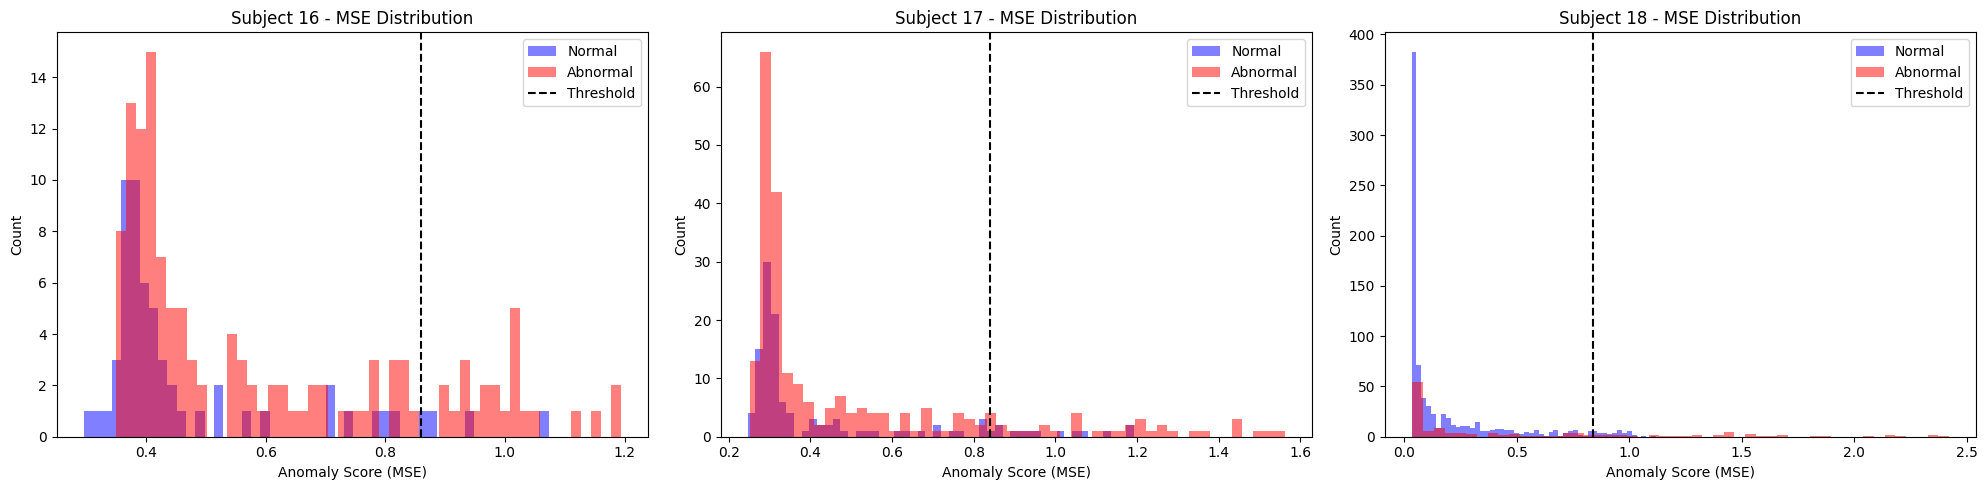

In [30]:
plt.figure(figsize=(20, 5))

# Subject 16
plt.subplot(1, 3, 1)
plt.hist(normal_scores_16, bins=50, alpha=0.5, color='blue', label='Normal')
plt.hist(abnormal_scores_16, bins=50, alpha=0.5, color='red', label='Abnormal')
threshold_16 = np.percentile(normal_scores_16, 95)
plt.axvline(threshold_16, color='black', linestyle='--', label='Threshold')
plt.title('Subject 16 - MSE Distribution')
plt.xlabel('Anomaly Score (MSE)')
plt.ylabel('Count')
plt.legend()

# Subject 17
plt.subplot(1, 3, 2)
plt.hist(normal_scores_17, bins=50, alpha=0.5, color='blue', label='Normal')
plt.hist(abnormal_scores_17, bins=50, alpha=0.5, color='red', label='Abnormal')
threshold_17 = np.percentile(normal_scores_18, 95)
plt.axvline(threshold_17, color='black', linestyle='--', label='Threshold')
plt.title('Subject 17 - MSE Distribution')
plt.xlabel('Anomaly Score (MSE)')
plt.ylabel('Count')
plt.legend()

# Subject 18
plt.subplot(1, 3, 3)
plt.hist(normal_scores_18, bins=50, alpha=0.5, color='blue', label='Normal')
plt.hist(abnormal_scores_18, bins=50, alpha=0.5, color='red', label='Abnormal')
threshold_18 = np.percentile(normal_scores_18, 95)
plt.axvline(threshold_18, color='black', linestyle='--', label='Threshold')
plt.title('Subject 18 - MSE Distribution')
plt.xlabel('Anomaly Score (MSE)')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

In [31]:
def create_error_df(normal_scores, abnormal_scores):
    return pd.DataFrame({
        'reconstruction_error': np.concatenate([normal_scores, abnormal_scores]),
        'true_class': np.concatenate([np.zeros(len(normal_scores)), np.ones(len(abnormal_scores))])
    })

error_df_16 = create_error_df(normal_scores_16, abnormal_scores_16)
error_df_17 = create_error_df(normal_scores_17, abnormal_scores_17)
error_df_18 = create_error_df(normal_scores_18, abnormal_scores_18)

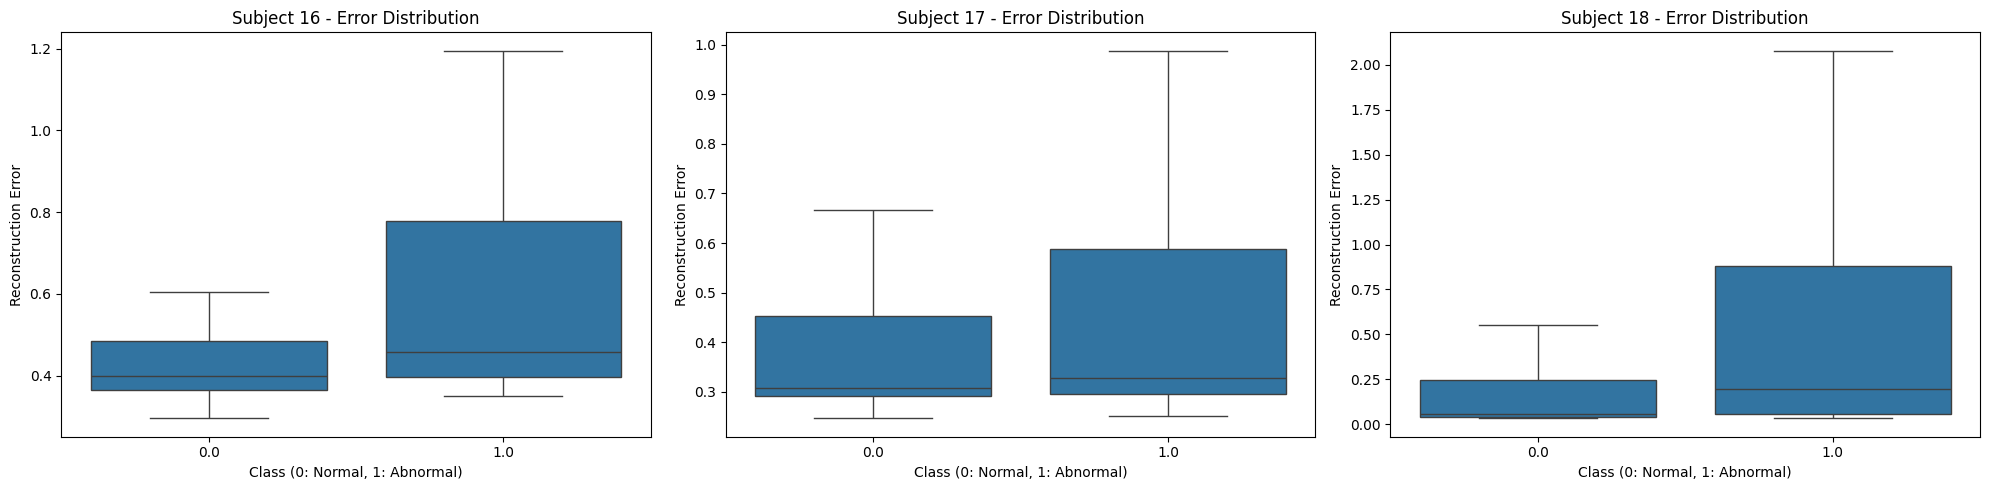

In [32]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='true_class', y='reconstruction_error', data=error_df_16, showfliers=False)
plt.title('Subject 16 - Error Distribution')
plt.ylabel('Reconstruction Error')
plt.xlabel('Class (0: Normal, 1: Abnormal)')

plt.subplot(1, 3, 2)
sns.boxplot(x='true_class', y='reconstruction_error', data=error_df_17, showfliers=False)
plt.title('Subject 17 - Error Distribution')
plt.ylabel('Reconstruction Error')
plt.xlabel('Class (0: Normal, 1: Abnormal)')

plt.subplot(1, 3, 3)
sns.boxplot(x='true_class', y='reconstruction_error', data=error_df_18, showfliers=False)
plt.title('Subject 18 - Error Distribution')
plt.ylabel('Reconstruction Error')
plt.xlabel('Class (0: Normal, 1: Abnormal)')

plt.tight_layout()
plt.show()

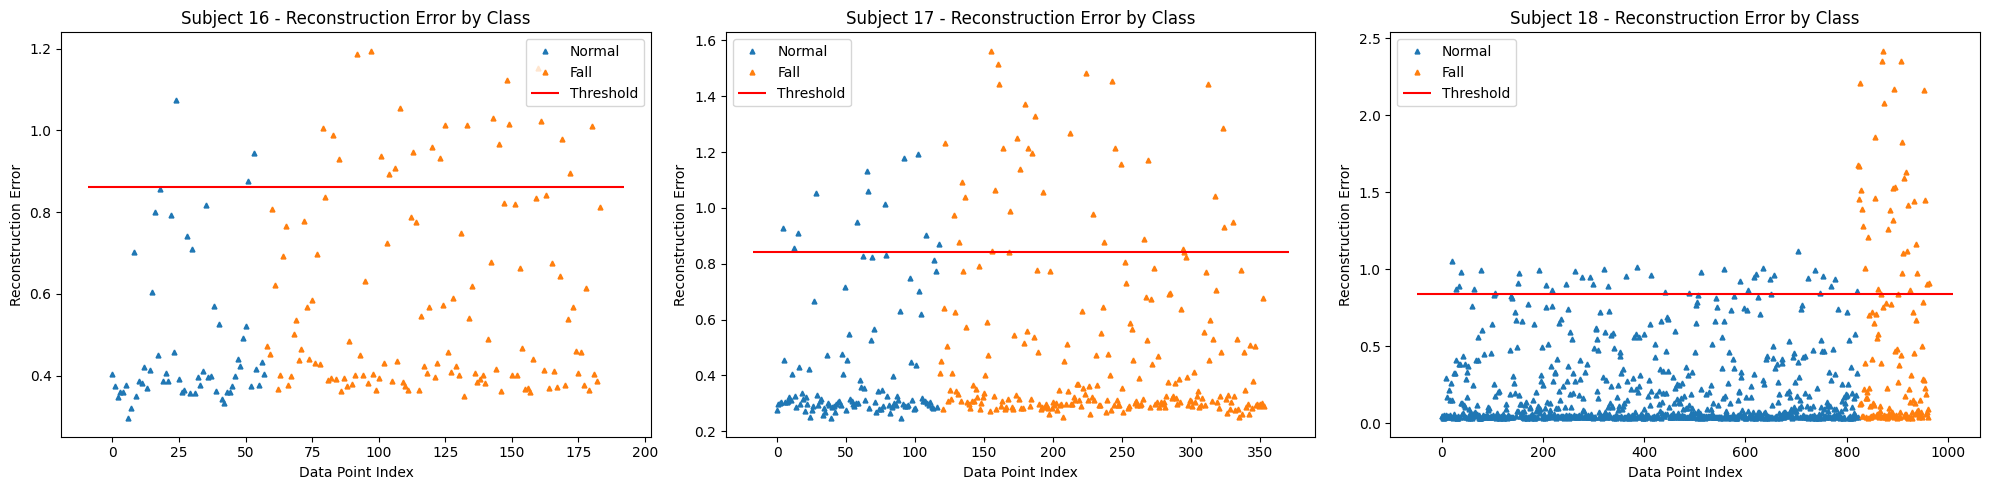

In [33]:
plt.figure(figsize=(20, 5))

# Subject 16
plt.subplot(1, 3, 1)
groups = error_df_16.groupby('true_class')
for name, group in groups:
    plt.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
             label="Normal" if name == 0 else "Fall")
plt.hlines(threshold_16, plt.xlim()[0], plt.xlim()[1], colors="r", zorder=100, label='Threshold')
plt.title("Subject 16 - Reconstruction Error by Class")
plt.ylabel("Reconstruction Error")
plt.xlabel("Data Point Index")
plt.legend()

# Subject 17
plt.subplot(1, 3, 2)
groups = error_df_17.groupby('true_class')
for name, group in groups:
    plt.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
             label="Normal" if name == 0 else "Fall")
plt.hlines(threshold_17, plt.xlim()[0], plt.xlim()[1], colors="r", zorder=100, label='Threshold')
plt.title("Subject 17 - Reconstruction Error by Class")
plt.ylabel("Reconstruction Error")
plt.xlabel("Data Point Index")
plt.legend()

# Subject 18
plt.subplot(1, 3, 3)
groups = error_df_18.groupby('true_class')
for name, group in groups:
    plt.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
             label="Normal" if name == 0 else "Fall")
plt.hlines(threshold_18, plt.xlim()[0], plt.xlim()[1], colors="r", zorder=100, label='Threshold')
plt.title("Subject 18 - Reconstruction Error by Class")
plt.ylabel("Reconstruction Error")
plt.xlabel("Data Point Index")
plt.legend()

plt.tight_layout()
plt.show()

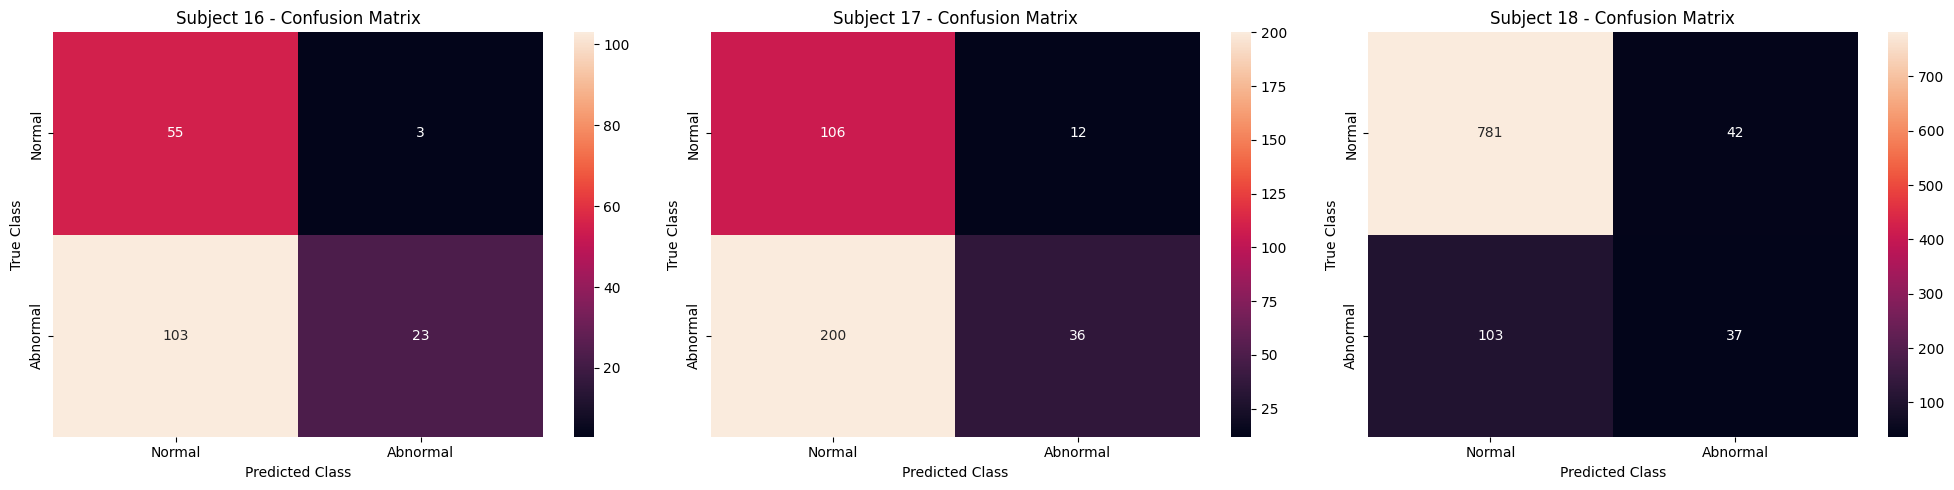

In [34]:
plt.figure(figsize=(20, 5))

# Subject 16
plt.subplot(1, 3, 1)
y_pred_16 = [1 if e > threshold_16 else 0 for e in error_df_16.reconstruction_error.values]
conf_matrix_16 = confusion_matrix(error_df_16.true_class, y_pred_16)
sns.heatmap(conf_matrix_16, xticklabels=["Normal", "Abnormal"], 
            yticklabels=["Normal", "Abnormal"], annot=True, fmt="d")
plt.title("Subject 16 - Confusion Matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

# Subject 17
plt.subplot(1, 3, 2)
y_pred_17 = [1 if e > threshold_17 else 0 for e in error_df_17.reconstruction_error.values]
conf_matrix_17 = confusion_matrix(error_df_17.true_class, y_pred_17)
sns.heatmap(conf_matrix_17, xticklabels=["Normal", "Abnormal"], 
            yticklabels=["Normal", "Abnormal"], annot=True, fmt="d")
plt.title("Subject 17 - Confusion Matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

# Subject 18
plt.subplot(1, 3, 3)
y_pred_18 = [1 if e > threshold_18 else 0 for e in error_df_18.reconstruction_error.values]
conf_matrix_18 = confusion_matrix(error_df_18.true_class, y_pred_18)
sns.heatmap(conf_matrix_18, xticklabels=["Normal", "Abnormal"], 
            yticklabels=["Normal", "Abnormal"], annot=True, fmt="d")
plt.title("Subject 18 - Confusion Matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

plt.tight_layout()
plt.show()

In [35]:
for subject_id, error_df, threshold in [
    (16, error_df_16, threshold_16),
    (17, error_df_17, threshold_17),
    (18, error_df_18, threshold_18)
]:
    y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
    y_true = error_df.true_class.values
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f'\nSubject {subject_id} Performance:')
    print(f'Accuracy Score : {accuracy:.4f}')
    print(f'Precision     : {precision:.4f}')
    print(f'Recall        : {recall:.4f}')
    print(f'F1 Score      : {f1:.4f}')


Subject 16 Performance:
Accuracy Score : 0.4239
Precision     : 0.8846
Recall        : 0.1825
F1 Score      : 0.3026

Subject 17 Performance:
Accuracy Score : 0.4011
Precision     : 0.7500
Recall        : 0.1525
F1 Score      : 0.2535

Subject 18 Performance:
Accuracy Score : 0.8494
Precision     : 0.4684
Recall        : 0.2643
F1 Score      : 0.3379
